In [1]:
# Load brain data and mask

# Access nifti, bval & bvec files
from os.path import expanduser, join
home = expanduser('~')
dname = join(home, 'brain-data-neil')

fdwi = join(dname, 'cdmri11_r.nii')
mask = join(dname, 'vol0083_brain_mask.nii.gz')
fbval = join(dname, 'parameters_new_bval.txt')
fbvec = join(dname, 'parameters_new_bvec2.txt')

# Load dMRI datasets 
from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi, return_img=True)
mask_data, affine1, img1 = load_nifti(mask, return_img=True)

# Check size of data --> (77, 92, 56, 1344)
print(data.shape)

(77, 92, 56, 1344)


In [2]:
# Set up acquisition scheme using bval, bvec

# Import relevant modules
from dmipy.core import modeling_framework
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from os.path import join
import numpy as np

# Load parameters and convert to SI units
bvalues = np.loadtxt(join('parameters_new_bval.txt'))  # given in s/m^2
bvalues_SI = bvalues * 1e6 # now given in SI units as s/mm^2
gradient_directions = np.loadtxt(join('parameters_new_bvec.txt'))
grad_echo_inv = np.loadtxt(join('parameters_new.txt'))
te = grad_echo_inv[:,5]/1e3
ti = grad_echo_inv[:,4]/1e3

# delta and Delta times in seconds
delta = 0.0242
Delta = 0.0391

# Acquisition scheme
acq_scheme = acquisition_scheme_from_bvalues(bvalues_SI, gradient_directions, delta, Delta)
acq_scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 1344
number of b0 measurements: 84
number of DWI shells: 4

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms]
0           |84        |0               |0                        |24.2       |39.1      |N/A  
1           |84        |500             |19                       |24.2       |39.1      |N/A  
2           |252       |1000            |27                       |24.2       |39.1      |N/A  
3           |420       |2000            |39                       |24.2       |39.1      |N/A  
4           |504       |3000            |48                       |24.2       |39.1      |N/A  


In [ ]:
print(grad_echo_inv)
ti = grad_echo_inv[:,4]
te = grad_echo_inv[:,5]
print(ti)
print(te)

In [ ]:
sub_data = data[:,:,:,te==80]
print(sub_data.shape)
sub_data = data[:,:,:,(ti>=3000) & (te==80) & (bvalues==3000)]
print(sub_data.shape) 

In [3]:
# Create sphere & stick model

# Import relevant modules
from dmipy.signal_models import cylinder_models, sphere_models
from dmipy.core.modeling_framework import MultiCompartmentModel

# Create ball and stick model
stick = cylinder_models.C1Stick()
sphere = sphere_models.S4SphereGaussianPhaseApproximation()
sphere_and_stick = MultiCompartmentModel(models=[sphere, stick])

print(sphere_and_stick.parameter_cardinality)

OrderedDict([('S4SphereGaussianPhaseApproximation_1_diameter', 1), ('C1Stick_1_mu', 2), ('C1Stick_1_lambda_par', 1), ('partial_volume_0', 1), ('partial_volume_1', 1)])


In [ ]:
SAS_fit = sphere_and_stick.fit(acq_scheme, data, mask=mask_data)

In [ ]:
mu = SAS_fit.fitted_parameters['C1Stick_1_mu']
print(mu)

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(mu[:,:,0])
ax2.imshow(mu[:,:,1])
ax1.set_title('C1Stick_1_mu')
ax2.set_title('C1Stick_1_mu')

In [ ]:
import numpy as np

diameter = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_SAS = sphere_and_stick.fit(acq_scheme, data[x,y,30,:])
            print(fitted_SAS.fitted_parameters['S4SphereGaussianPhaseApproximation_1_diameter'])
            diameter[x,y,:] = fitted_SAS.fitted_parameters['S4SphereGaussianPhaseApproximation_1_diameter']
            print((x, y))
            
print(diameter)

In [ ]:
# Save diameter as a nifti file to view on FSLeyes
from dipy.io.image import save_nifti
save_nifti('SAS_sphere_diameter.nii.gz', diameter, affine)

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.imshow(part_vol_zero, vmin=0, vmax=1)
# ax2.imshow(diameter[:,:,1])
ax1.set_title('S4SphereGaussianPhaseApproximation_1_diameter')
print(np.min(diameter))
# ax2.set_title('S4SphereGaussianPhaseApproximation_1_diameter')

In [ ]:
with open('SAS_sphere_diameter.txt', 'w') as file:
    for line in diameter:
        file.write("%s\n" %line)
        
file.close()

In [ ]:
import numpy as np

part_vol_zero = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_SAS = sphere_and_stick.fit(acq_scheme, data[x,y,30,:])
            print(fitted_SAS.fitted_parameters['partial_volume_0'])
            part_vol_zero[x,y,:] = fitted_SAS.fitted_parameters['partial_volume_0']
            print((x, y))
            
print(part_vol_zero)

In [ ]:
# Save partial volume 0 as a nifti file to view on FSLeyes
from dipy.io.image import save_nifti
save_nifti('SAS_partial_volume_0.nii.gz', part_vol_zero, affine)

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(part_vol_zero[:,:,0])
ax2.imshow(part_vol_zero[:,:,1])
ax1.set_title('partial_volume_0')
ax2.set_title('partial_volume_0')

In [ ]:
with open('SAS_partial_volume_0.txt', 'w') as file:
    for line in part_vol_zero:
        file.write("%s\n" %line)
        
file.close()

In [ ]:
import numpy as np

part_vol_one = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_SAS = sphere_and_stick.fit(acq_scheme, data[x,y,30,:])
            print(fitted_SAS.fitted_parameters['partial_volume_1'])
            part_vol_one[x,y,:] = fitted_SAS.fitted_parameters['partial_volume_1']
            print((x, y))
            
print(part_vol_one)

In [ ]:
# Save partial volume 1 as a nifti file to view on FSLeyes
from dipy.io.image import save_nifti
save_nifti('SAS_partial_volume_1.nii.gz', part_vol_one, affine)

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(part_vol_one[:,:,0])
ax2.imshow(part_vol_one[:,:,1])
ax1.set_title('partial_volume_1')
ax2.set_title('partial_volume_1')

In [ ]:
with open('SAS_partial_volume_1.txt', 'w') as file:
    for line in part_vol_one:
        file.write("%s\n" %line)
        
file.close()

In [9]:
import numpy as np

mu = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_SAS = sphere_and_stick.fit(acq_scheme, data[x,y,30,:])
            print(fitted_SAS.fitted_parameters['C1Stick_1_mu'])
            mu[x,y,:] = fitted_SAS.fitted_parameters['C1Stick_1_mu']
            print((x, y))
            
print(mu)

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3381149768829346 seconds
Fitting of 1 voxels complete in 0.068817138671875 seconds.
Average of 0.068817138671875 seconds per voxel.
[[1.04880736 0.18273575]]
(14, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6203248500823975 seconds
Fitting of 1 voxels complete in 0.06692814826965332 seconds.
Average of 0.06692814826965332 seconds per voxel.
[[2.10025981 2.92463012]]
(14, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.380072832107544 seconds
Fitting of 1 voxels complete in 0.07529211044311523 seconds.
Average of 0.07529211044311523 seconds per voxel.
[[2.01653462 2.88480909]]
(14, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2742958068847656 seconds
Fitting of 1 voxels complete in 0.06577205657958984 seconds.
Average of 0.06577205657958984 seconds per voxel.
[[ 0.96427651 -0.82586308]]
(14, 37)
Using parallel processi

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4043619632720947 seconds
Fitting of 1 voxels complete in 0.09420990943908691 seconds.
Average of 0.09420990943908691 seconds per voxel.
[[1.04269334 0.15785944]]
(16, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7761831283569336 seconds
Fitting of 1 voxels complete in 0.0770108699798584 seconds.
Average of 0.0770108699798584 seconds per voxel.
[[1.02416573 0.1976506 ]]
(16, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.315291166305542 seconds
Fitting of 1 voxels complete in 0.07285618782043457 seconds.
Average of 0.07285618782043457 seconds per voxel.
[[1.03091807 0.17490341]]
(16, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.813004970550537 seconds
Fitting of 1 voxels complete in 0.14194369316101074 seconds.
Average of 0.14194369316101074 seconds per voxel.
[[ 0.98604484 -0.80726067]]
(16, 39)
Using parallel process

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.24202299118042 seconds
Fitting of 1 voxels complete in 0.057085275650024414 seconds.
Average of 0.057085275650024414 seconds per voxel.
[[0.94151688 1.63759156]]
(17, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2392702102661133 seconds
Fitting of 1 voxels complete in 0.07789897918701172 seconds.
Average of 0.07789897918701172 seconds per voxel.
[[2.04334547 0.88877038]]
(17, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6783649921417236 seconds
Fitting of 1 voxels complete in 0.08404111862182617 seconds.
Average of 0.08404111862182617 seconds per voxel.
[[2.39598312 0.96832638]]
(17, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3356192111968994 seconds
Fitting of 1 voxels complete in 0.07198500633239746 seconds.
Average of 0.07198500633239746 seconds per voxel.
[[2.39671612 0.99459729]]
(17, 48)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4160058498382568 seconds
Fitting of 1 voxels complete in 0.08959603309631348 seconds.
Average of 0.08959603309631348 seconds per voxel.
[[1.29131617 0.55491665]]
(18, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4540839195251465 seconds
Fitting of 1 voxels complete in 0.0774068832397461 seconds.
Average of 0.0774068832397461 seconds per voxel.
[[ 2.99544589 -0.71927089]]
(18, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3616931438446045 seconds
Fitting of 1 voxels complete in 0.06536388397216797 seconds.
Average of 0.06536388397216797 seconds per voxel.
[[1.46158383 2.42833088]]
(18, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2931699752807617 seconds
Fitting of 1 voxels complete in 0.06341314315795898 seconds.
Average of 0.06341314315795898 seconds per voxel.
[[2.27108995 2.95992115]]
(18, 54)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.0206241607666016 seconds
Fitting of 1 voxels complete in 0.07756376266479492 seconds.
Average of 0.07756376266479492 seconds per voxel.
[[ 1.00266792 -0.79646901]]
(19, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5286190509796143 seconds
Fitting of 1 voxels complete in 0.07877087593078613 seconds.
Average of 0.07877087593078613 seconds per voxel.
[[ 0.96309622 -0.83202618]]
(19, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5122478008270264 seconds
Fitting of 1 voxels complete in 0.07905292510986328 seconds.
Average of 0.07905292510986328 seconds per voxel.
[[ 0.96906663 -0.83624437]]
(19, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2564918994903564 seconds
Fitting of 1 voxels complete in 0.0676870346069336 seconds.
Average of 0.0676870346069336 seconds per voxel.
[[1.49841432 2.50475694]]
(19, 52)
Using parallel p

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.582016944885254 seconds
Fitting of 1 voxels complete in 0.09013605117797852 seconds.
Average of 0.09013605117797852 seconds per voxel.
[[1.01320663 1.60983048]]
(20, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.0444769859313965 seconds
Fitting of 1 voxels complete in 0.11135101318359375 seconds.
Average of 0.11135101318359375 seconds per voxel.
[[ 0.98526093 -0.70342403]]
(20, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.21915602684021 seconds
Fitting of 1 voxels complete in 0.16284608840942383 seconds.
Average of 0.16284608840942383 seconds per voxel.
[[2.0315376  2.66791878]]
(20, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.396148920059204 seconds
Fitting of 1 voxels complete in 0.18597698211669922 seconds.
Average of 0.18597698211669922 seconds per voxel.
[[1.91591655 2.64797815]]
(20, 46)
Using parallel process

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3742997646331787 seconds
Fitting of 1 voxels complete in 0.07672286033630371 seconds.
Average of 0.07672286033630371 seconds per voxel.
[[ 0.9493826  -0.79039878]]
(21, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3664891719818115 seconds
Fitting of 1 voxels complete in 0.07198596000671387 seconds.
Average of 0.07198596000671387 seconds per voxel.
[[ 0.93438255 -0.74922411]]
(21, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6475629806518555 seconds
Fitting of 1 voxels complete in 0.06688499450683594 seconds.
Average of 0.06688499450683594 seconds per voxel.
[[ 0.93067722 -0.74453433]]
(21, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3730449676513672 seconds
Fitting of 1 voxels complete in 0.0682377815246582 seconds.
Average of 0.0682377815246582 seconds per voxel.
[[2.09092086 2.78355917]]
(21, 36)
Using parallel p

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.371636152267456 seconds
Fitting of 1 voxels complete in 0.0763540267944336 seconds.
Average of 0.0763540267944336 seconds per voxel.
[[0.88406335 1.65377585]]
(22, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6571080684661865 seconds
Fitting of 1 voxels complete in 0.07041168212890625 seconds.
Average of 0.07041168212890625 seconds per voxel.
[[0.8722543  1.63135165]]
(22, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.527144193649292 seconds
Fitting of 1 voxels complete in 0.06821608543395996 seconds.
Average of 0.06821608543395996 seconds per voxel.
[[0.89090508 1.61996783]]
(22, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3884143829345703 seconds
Fitting of 1 voxels complete in 0.07576799392700195 seconds.
Average of 0.07576799392700195 seconds per voxel.
[[1.05089684 0.21590287]]
(22, 22)
Using parallel processin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7701640129089355 seconds
Fitting of 1 voxels complete in 0.08585190773010254 seconds.
Average of 0.08585190773010254 seconds per voxel.
[[2.2268007  2.93738939]]
(22, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7267601490020752 seconds
Fitting of 1 voxels complete in 0.07837986946105957 seconds.
Average of 0.07837986946105957 seconds per voxel.
[[2.20349174 2.72968508]]
(22, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7279300689697266 seconds
Fitting of 1 voxels complete in 0.0958409309387207 seconds.
Average of 0.0958409309387207 seconds per voxel.
[[ 0.95570751 -0.75575673]]
(22, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.692798376083374 seconds
Fitting of 1 voxels complete in 0.061895132064819336 seconds.
Average of 0.061895132064819336 seconds per voxel.
[[0.92535509 1.60215412]]
(22, 56)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6328320503234863 seconds
Fitting of 1 voxels complete in 0.09543395042419434 seconds.
Average of 0.09543395042419434 seconds per voxel.
[[ 0.91023135 -0.81362974]]
(23, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7123868465423584 seconds
Fitting of 1 voxels complete in 0.08568406105041504 seconds.
Average of 0.08568406105041504 seconds per voxel.
[[1.80054671 1.46476175]]
(23, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6768639087677002 seconds
Fitting of 1 voxels complete in 0.07606196403503418 seconds.
Average of 0.07606196403503418 seconds per voxel.
[[2.19432287 2.87400809]]
(23, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.662330150604248 seconds
Fitting of 1 voxels complete in 0.08452200889587402 seconds.
Average of 0.08452200889587402 seconds per voxel.
[[2.12280175 2.87473813]]
(23, 40)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6648712158203125 seconds
Fitting of 1 voxels complete in 0.08684992790222168 seconds.
Average of 0.08684992790222168 seconds per voxel.
[[0.84207241 1.64168764]]
(24, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6826801300048828 seconds
Fitting of 1 voxels complete in 0.08461594581604004 seconds.
Average of 0.08461594581604004 seconds per voxel.
[[0.87035568 1.63995403]]
(24, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6935451030731201 seconds
Fitting of 1 voxels complete in 0.08569908142089844 seconds.
Average of 0.08569908142089844 seconds per voxel.
[[0.85885818 1.63840579]]
(24, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.8205807209014893 seconds
Fitting of 1 voxels complete in 0.09456992149353027 seconds.
Average of 0.09456992149353027 seconds per voxel.
[[1.03783024 0.17972844]]
(24, 21)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6747610569000244 seconds
Fitting of 1 voxels complete in 0.08695197105407715 seconds.
Average of 0.08695197105407715 seconds per voxel.
[[1.99843521 2.79289642]]
(24, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7573890686035156 seconds
Fitting of 1 voxels complete in 0.07697510719299316 seconds.
Average of 0.07697510719299316 seconds per voxel.
[[2.06920163 2.79933984]]
(24, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7602858543395996 seconds
Fitting of 1 voxels complete in 0.07941293716430664 seconds.
Average of 0.07941293716430664 seconds per voxel.
[[2.17006393 2.81568779]]
(24, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.695617914199829 seconds
Fitting of 1 voxels complete in 0.08608698844909668 seconds.
Average of 0.08608698844909668 seconds per voxel.
[[2.21652867 2.87475492]]
(24, 55)
Using parallel proces

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.741020917892456 seconds
Fitting of 1 voxels complete in 0.0825951099395752 seconds.
Average of 0.0825951099395752 seconds per voxel.
[[ 0.92899312 -2.72120408]]
(25, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7848918437957764 seconds
Fitting of 1 voxels complete in 0.08228802680969238 seconds.
Average of 0.08228802680969238 seconds per voxel.
[[ 0.99290208 -2.57877374]]
(25, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6968958377838135 seconds
Fitting of 1 voxels complete in 0.0873110294342041 seconds.
Average of 0.0873110294342041 seconds per voxel.
[[0.76773537 1.45762294]]
(25, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.675013780593872 seconds
Fitting of 1 voxels complete in 0.08239316940307617 seconds.
Average of 0.08239316940307617 seconds per voxel.
[[1.498401   2.42602863]]
(25, 32)
Using parallel process

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.640519142150879 seconds
Fitting of 1 voxels complete in 0.08822512626647949 seconds.
Average of 0.08822512626647949 seconds per voxel.
[[1.46305986 2.28376583]]
(25, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7201788425445557 seconds
Fitting of 1 voxels complete in 0.0705718994140625 seconds.
Average of 0.0705718994140625 seconds per voxel.
[[1.48551257 2.26637505]]
(25, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.705639123916626 seconds
Fitting of 1 voxels complete in 0.10053181648254395 seconds.
Average of 0.10053181648254395 seconds per voxel.
[[1.71599091 2.07270653]]
(25, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6647791862487793 seconds
Fitting of 1 voxels complete in 0.08132505416870117 seconds.
Average of 0.08132505416870117 seconds per voxel.
[[1.78176663 2.10488784]]
(25, 66)
Using parallel processin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7761609554290771 seconds
Fitting of 1 voxels complete in 0.08359098434448242 seconds.
Average of 0.08359098434448242 seconds per voxel.
[[1.07663449 2.58482884]]
(26, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.9370660781860352 seconds
Fitting of 1 voxels complete in 0.09305310249328613 seconds.
Average of 0.09305310249328613 seconds per voxel.
[[ 0.71017866 -2.38759132]]
(26, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.8002471923828125 seconds
Fitting of 1 voxels complete in 0.0783088207244873 seconds.
Average of 0.0783088207244873 seconds per voxel.
[[0.92374017 1.63234088]]
(26, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7457199096679688 seconds
Fitting of 1 voxels complete in 0.0838770866394043 seconds.
Average of 0.0838770866394043 seconds per voxel.
[[0.88372345 1.67140175]]
(26, 42)
Using parallel process

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.91926908493042 seconds
Fitting of 1 voxels complete in 0.15248775482177734 seconds.
Average of 0.15248775482177734 seconds per voxel.
[[1.54673425 2.60063107]]
(27, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7515220642089844 seconds
Fitting of 1 voxels complete in 0.08150506019592285 seconds.
Average of 0.08150506019592285 seconds per voxel.
[[0.84000697 1.65548666]]
(27, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7221958637237549 seconds
Fitting of 1 voxels complete in 0.09456610679626465 seconds.
Average of 0.09456610679626465 seconds per voxel.
[[1.79880353 3.06291277]]
(27, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6835718154907227 seconds
Fitting of 1 voxels complete in 0.08853888511657715 seconds.
Average of 0.08853888511657715 seconds per voxel.
[[ 1.00563143 -1.69429201]]
(27, 17)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7299211025238037 seconds
Fitting of 1 voxels complete in 0.08435511589050293 seconds.
Average of 0.08435511589050293 seconds per voxel.
[[2.14559113 2.79545242]]
(27, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6931979656219482 seconds
Fitting of 1 voxels complete in 0.08696603775024414 seconds.
Average of 0.08696603775024414 seconds per voxel.
[[2.22992532 2.80251175]]
(27, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.672849178314209 seconds
Fitting of 1 voxels complete in 0.08067798614501953 seconds.
Average of 0.08067798614501953 seconds per voxel.
[[2.2433026  2.76943006]]
(27, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.674109935760498 seconds
Fitting of 1 voxels complete in 0.07903599739074707 seconds.
Average of 0.07903599739074707 seconds per voxel.
[[2.27599597 2.75856285]]
(27, 51)
Using parallel process

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.700530767440796 seconds
Fitting of 1 voxels complete in 0.0798180103302002 seconds.
Average of 0.0798180103302002 seconds per voxel.
[[ 0.77298605 -1.21263988]]
(28, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6495709419250488 seconds
Fitting of 1 voxels complete in 0.11336779594421387 seconds.
Average of 0.11336779594421387 seconds per voxel.
[[ 0.88380029 -1.71683581]]
(28, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.9702141284942627 seconds
Fitting of 1 voxels complete in 0.0871438980102539 seconds.
Average of 0.0871438980102539 seconds per voxel.
[[0.87199832 1.52877035]]
(28, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.664412021636963 seconds
Fitting of 1 voxels complete in 0.0806879997253418 seconds.
Average of 0.0806879997253418 seconds per voxel.
[[0.90653054 1.56487568]]
(28, 25)
Using parallel processin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7319989204406738 seconds
Fitting of 1 voxels complete in 0.0887458324432373 seconds.
Average of 0.0887458324432373 seconds per voxel.
[[0.90057411 0.20974882]]
(28, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.687323808670044 seconds
Fitting of 1 voxels complete in 0.08249998092651367 seconds.
Average of 0.08249998092651367 seconds per voxel.
[[0.93249918 0.14887667]]
(28, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.646894931793213 seconds
Fitting of 1 voxels complete in 0.07261919975280762 seconds.
Average of 0.07261919975280762 seconds per voxel.
[[0.98194885 0.1241833 ]]
(28, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.672497272491455 seconds
Fitting of 1 voxels complete in 0.08441495895385742 seconds.
Average of 0.08441495895385742 seconds per voxel.
[[1.03317333 0.09745314]]
(28, 59)
Using parallel processing

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6951770782470703 seconds
Fitting of 1 voxels complete in 0.07389593124389648 seconds.
Average of 0.07389593124389648 seconds per voxel.
[[2.0538845  2.02935565]]
(29, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.685070276260376 seconds
Fitting of 1 voxels complete in 0.08481192588806152 seconds.
Average of 0.08481192588806152 seconds per voxel.
[[ 1.00372802 -1.14851154]]
(29, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6562647819519043 seconds
Fitting of 1 voxels complete in 0.10827398300170898 seconds.
Average of 0.10827398300170898 seconds per voxel.
[[2.10205208 0.92863986]]
(29, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6781082153320312 seconds
Fitting of 1 voxels complete in 0.1082160472869873 seconds.
Average of 0.1082160472869873 seconds per voxel.
[[1.03972609 0.57435449]]
(29, 32)
Using parallel proces

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7037498950958252 seconds
Fitting of 1 voxels complete in 0.11281585693359375 seconds.
Average of 0.11281585693359375 seconds per voxel.
[[1.63522506 2.51257765]]
(29, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6594018936157227 seconds
Fitting of 1 voxels complete in 0.0830221176147461 seconds.
Average of 0.0830221176147461 seconds per voxel.
[[1.82044314 2.12663138]]
(29, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.665550947189331 seconds
Fitting of 1 voxels complete in 0.06876516342163086 seconds.
Average of 0.06876516342163086 seconds per voxel.
[[ 1.82531733 -1.32550431]]
(29, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7342379093170166 seconds
Fitting of 1 voxels complete in 0.0846247673034668 seconds.
Average of 0.0846247673034668 seconds per voxel.
[[ 1.96575279 -1.21728148]]
(29, 66)
Using parallel proces

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6886661052703857 seconds
Fitting of 1 voxels complete in 0.09136271476745605 seconds.
Average of 0.09136271476745605 seconds per voxel.
[[2.47132098 0.9843256 ]]
(30, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6502759456634521 seconds
Fitting of 1 voxels complete in 0.08740901947021484 seconds.
Average of 0.08740901947021484 seconds per voxel.
[[2.53699418 0.99658841]]
(30, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7019321918487549 seconds
Fitting of 1 voxels complete in 0.0708773136138916 seconds.
Average of 0.0708773136138916 seconds per voxel.
[[2.66000485 1.03732901]]
(30, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6746039390563965 seconds
Fitting of 1 voxels complete in 0.09480810165405273 seconds.
Average of 0.09480810165405273 seconds per voxel.
[[2.78812262 1.1255183 ]]
(30, 38)
Using parallel process

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7112321853637695 seconds
Fitting of 1 voxels complete in 0.09922289848327637 seconds.
Average of 0.09922289848327637 seconds per voxel.
[[ 1.62470202 -0.58364031]]
(30, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6867599487304688 seconds
Fitting of 1 voxels complete in 0.09251999855041504 seconds.
Average of 0.09251999855041504 seconds per voxel.
[[1.5048562  2.55004005]]
(30, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6679952144622803 seconds
Fitting of 1 voxels complete in 0.08750510215759277 seconds.
Average of 0.08750510215759277 seconds per voxel.
[[ 1.64217744 -0.52815479]]
(30, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6963489055633545 seconds
Fitting of 1 voxels complete in 0.07035517692565918 seconds.
Average of 0.07035517692565918 seconds per voxel.
[[ 1.67658669 -0.43256034]]
(30, 72)
Using parallel

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6543560028076172 seconds
Fitting of 1 voxels complete in 0.09554600715637207 seconds.
Average of 0.09554600715637207 seconds per voxel.
[[2.87574989 1.01353199]]
(31, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.678529977798462 seconds
Fitting of 1 voxels complete in 0.09749913215637207 seconds.
Average of 0.09749913215637207 seconds per voxel.
[[2.87677162 1.09595045]]
(31, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6905441284179688 seconds
Fitting of 1 voxels complete in 0.09506726264953613 seconds.
Average of 0.09506726264953613 seconds per voxel.
[[2.82136171 0.05260294]]
(31, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.665806770324707 seconds
Fitting of 1 voxels complete in 0.08869194984436035 seconds.
Average of 0.08869194984436035 seconds per voxel.
[[ 2.62888871 -0.46055496]]
(31, 42)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.280226230621338 seconds
Fitting of 1 voxels complete in 0.06617617607116699 seconds.
Average of 0.06617617607116699 seconds per voxel.
[[1.87106103 2.90025092]]
(31, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2604849338531494 seconds
Fitting of 1 voxels complete in 0.06428885459899902 seconds.
Average of 0.06428885459899902 seconds per voxel.
[[2.31921725 2.90794446]]
(32, 10)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4632909297943115 seconds
Fitting of 1 voxels complete in 0.06243085861206055 seconds.
Average of 0.06243085861206055 seconds per voxel.
[[2.32754772 2.92678257]]
(32, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6171629428863525 seconds
Fitting of 1 voxels complete in 0.08768725395202637 seconds.
Average of 0.08768725395202637 seconds per voxel.
[[0.892474   1.61320474]]
(32, 12)
Using parallel proces

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2645397186279297 seconds
Fitting of 1 voxels complete in 0.06362700462341309 seconds.
Average of 0.06362700462341309 seconds per voxel.
[[ 2.54853659 -0.58961792]]
(32, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2523391246795654 seconds
Fitting of 1 voxels complete in 0.060220956802368164 seconds.
Average of 0.060220956802368164 seconds per voxel.
[[ 2.50631466 -0.64683428]]
(32, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2668681144714355 seconds
Fitting of 1 voxels complete in 0.06563401222229004 seconds.
Average of 0.06563401222229004 seconds per voxel.
[[ 2.457873   -0.66991076]]
(32, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.259202241897583 seconds
Fitting of 1 voxels complete in 0.06159496307373047 seconds.
Average of 0.06159496307373047 seconds per voxel.
[[ 2.38146274 -0.82228395]]
(32, 46)
Using paral

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.262819766998291 seconds
Fitting of 1 voxels complete in 0.08062291145324707 seconds.
Average of 0.08062291145324707 seconds per voxel.
[[2.55285332 1.96505011]]
(33, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.262044906616211 seconds
Fitting of 1 voxels complete in 0.0681009292602539 seconds.
Average of 0.0681009292602539 seconds per voxel.
[[ 0.93670075 -0.77612841]]
(33, 12)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.267104148864746 seconds
Fitting of 1 voxels complete in 0.06496000289916992 seconds.
Average of 0.06496000289916992 seconds per voxel.
[[ 1.70538596 -0.47064418]]
(33, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2633109092712402 seconds
Fitting of 1 voxels complete in 0.0631098747253418 seconds.
Average of 0.0631098747253418 seconds per voxel.
[[0.87837558 1.61612443]]
(33, 14)
Using parallel processi

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.261888027191162 seconds
Fitting of 1 voxels complete in 0.06061601638793945 seconds.
Average of 0.06061601638793945 seconds per voxel.
[[ 2.35239249 -0.83909597]]
(33, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2541282176971436 seconds
Fitting of 1 voxels complete in 0.057396888732910156 seconds.
Average of 0.057396888732910156 seconds per voxel.
[[ 2.30664074 -0.87890222]]
(33, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2616889476776123 seconds
Fitting of 1 voxels complete in 0.0563199520111084 seconds.
Average of 0.0563199520111084 seconds per voxel.
[[ 2.28792856 -0.89642513]]
(33, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2622089385986328 seconds
Fitting of 1 voxels complete in 0.05475878715515137 seconds.
Average of 0.05475878715515137 seconds per voxel.
[[ 2.18254419 -0.98227034]]
(33, 48)
Using paralle

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2682406902313232 seconds
Fitting of 1 voxels complete in 0.06280303001403809 seconds.
Average of 0.06280303001403809 seconds per voxel.
[[2.26379536 2.90231171]]
(34, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2627251148223877 seconds
Fitting of 1 voxels complete in 0.06032395362854004 seconds.
Average of 0.06032395362854004 seconds per voxel.
[[0.91207102 1.65623319]]
(34, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2633697986602783 seconds
Fitting of 1 voxels complete in 0.057549238204956055 seconds.
Average of 0.057549238204956055 seconds per voxel.
[[ 0.86506045 -0.88627866]]
(34, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2633659839630127 seconds
Fitting of 1 voxels complete in 0.06339693069458008 seconds.
Average of 0.06339693069458008 seconds per voxel.
[[ 0.99405606 -0.93284568]]
(34, 16)
Using parallel

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2901439666748047 seconds
Fitting of 1 voxels complete in 0.05816817283630371 seconds.
Average of 0.05816817283630371 seconds per voxel.
[[ 2.17508984 -0.95896012]]
(34, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2546579837799072 seconds
Fitting of 1 voxels complete in 0.05606508255004883 seconds.
Average of 0.05606508255004883 seconds per voxel.
[[ 2.15551694 -0.99198914]]
(34, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2619121074676514 seconds
Fitting of 1 voxels complete in 0.05966377258300781 seconds.
Average of 0.05966377258300781 seconds per voxel.
[[ 2.12871969 -1.01992541]]
(34, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5059199333190918 seconds
Fitting of 1 voxels complete in 0.05773210525512695 seconds.
Average of 0.05773210525512695 seconds per voxel.
[[ 2.03765646 -1.05370857]]
(34, 50)
Using parall

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.263197898864746 seconds
Fitting of 1 voxels complete in 0.058775901794433594 seconds.
Average of 0.058775901794433594 seconds per voxel.
[[ 1.03652381 -0.82606061]]
(35, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2787718772888184 seconds
Fitting of 1 voxels complete in 0.06496405601501465 seconds.
Average of 0.06496405601501465 seconds per voxel.
[[ 1.08527486 -0.97710387]]
(35, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2618918418884277 seconds
Fitting of 1 voxels complete in 0.0636906623840332 seconds.
Average of 0.0636906623840332 seconds per voxel.
[[2.223895   2.88607458]]
(35, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2615621089935303 seconds
Fitting of 1 voxels complete in 0.0605008602142334 seconds.
Average of 0.0605008602142334 seconds per voxel.
[[1.54757427 2.36847717]]
(35, 19)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.380439043045044 seconds
Fitting of 1 voxels complete in 0.060320138931274414 seconds.
Average of 0.060320138931274414 seconds per voxel.
[[ 2.09181812 -1.07479161]]
(35, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2727160453796387 seconds
Fitting of 1 voxels complete in 0.062255144119262695 seconds.
Average of 0.062255144119262695 seconds per voxel.
[[ 2.12017103 -1.14219953]]
(35, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2659428119659424 seconds
Fitting of 1 voxels complete in 0.061650991439819336 seconds.
Average of 0.061650991439819336 seconds per voxel.
[[ 2.14241388 -1.11680536]]
(35, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2751262187957764 seconds
Fitting of 1 voxels complete in 0.06841683387756348 seconds.
Average of 0.06841683387756348 seconds per voxel.
[[ 1.88574427 -0.96738353]]
(35, 53)
Using p

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2574188709259033 seconds
Fitting of 1 voxels complete in 0.061347007751464844 seconds.
Average of 0.061347007751464844 seconds per voxel.
[[1.73834296 2.12959127]]
(36, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2593982219696045 seconds
Fitting of 1 voxels complete in 0.06887197494506836 seconds.
Average of 0.06887197494506836 seconds per voxel.
[[1.70550174 2.1091231 ]]
(36, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2866411209106445 seconds
Fitting of 1 voxels complete in 0.09115004539489746 seconds.
Average of 0.09115004539489746 seconds per voxel.
[[1.76106596 2.14704021]]
(36, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2580032348632812 seconds
Fitting of 1 voxels complete in 0.0627293586730957 seconds.
Average of 0.0627293586730957 seconds per voxel.
[[0.83884801 1.61677018]]
(36, 22)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2840499877929688 seconds
Fitting of 1 voxels complete in 0.0697779655456543 seconds.
Average of 0.0697779655456543 seconds per voxel.
[[ 1.90386846 -1.05259405]]
(36, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2783710956573486 seconds
Fitting of 1 voxels complete in 0.05646181106567383 seconds.
Average of 0.05646181106567383 seconds per voxel.
[[1.42395649 2.35785828]]
(36, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2629637718200684 seconds
Fitting of 1 voxels complete in 0.06335592269897461 seconds.
Average of 0.06335592269897461 seconds per voxel.
[[1.45623537 2.41700173]]
(36, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.260756015777588 seconds
Fitting of 1 voxels complete in 0.062196969985961914 seconds.
Average of 0.062196969985961914 seconds per voxel.
[[1.46134972 2.41522698]]
(36, 56)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2813529968261719 seconds
Fitting of 1 voxels complete in 0.06184697151184082 seconds.
Average of 0.06184697151184082 seconds per voxel.
[[0.88488981 1.62726974]]
(37, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2859327793121338 seconds
Fitting of 1 voxels complete in 0.06043696403503418 seconds.
Average of 0.06043696403503418 seconds per voxel.
[[0.91287545 1.60982079]]
(37, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2831170558929443 seconds
Fitting of 1 voxels complete in 0.07259964942932129 seconds.
Average of 0.07259964942932129 seconds per voxel.
[[0.96832372 1.08175151]]
(37, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2844247817993164 seconds
Fitting of 1 voxels complete in 0.07463812828063965 seconds.
Average of 0.07463812828063965 seconds per voxel.
[[1.99687771 2.78818325]]
(37, 26)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3203058242797852 seconds
Fitting of 1 voxels complete in 0.058915138244628906 seconds.
Average of 0.058915138244628906 seconds per voxel.
[[ 1.7099258  -0.51021581]]
(37, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3053100109100342 seconds
Fitting of 1 voxels complete in 0.054882049560546875 seconds.
Average of 0.054882049560546875 seconds per voxel.
[[ 1.68237201 -0.472939  ]]
(37, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3057518005371094 seconds
Fitting of 1 voxels complete in 0.056792259216308594 seconds.
Average of 0.056792259216308594 seconds per voxel.
[[ 1.67211072 -0.46264011]]
(37, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.284712314605713 seconds
Fitting of 1 voxels complete in 0.06722402572631836 seconds.
Average of 0.06722402572631836 seconds per voxel.
[[2.59181178 2.03095791]]
(37, 60)
Using par

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2588207721710205 seconds
Fitting of 1 voxels complete in 0.06388306617736816 seconds.
Average of 0.06388306617736816 seconds per voxel.
[[2.06055283 2.36314233]]
(38, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2532129287719727 seconds
Fitting of 1 voxels complete in 0.06653189659118652 seconds.
Average of 0.06653189659118652 seconds per voxel.
[[0.87784852 1.52166657]]
(38, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2601051330566406 seconds
Fitting of 1 voxels complete in 0.08391404151916504 seconds.
Average of 0.08391404151916504 seconds per voxel.
[[0.89592998 1.18251112]]
(38, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2636888027191162 seconds
Fitting of 1 voxels complete in 0.0628657341003418 seconds.
Average of 0.0628657341003418 seconds per voxel.
[[0.77997179 1.31952755]]
(38, 30)
Using parallel process

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.29170823097229 seconds
Fitting of 1 voxels complete in 0.07041525840759277 seconds.
Average of 0.07041525840759277 seconds per voxel.
[[2.59040001 2.00571544]]
(38, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2674367427825928 seconds
Fitting of 1 voxels complete in 0.07002687454223633 seconds.
Average of 0.07002687454223633 seconds per voxel.
[[ 0.75599178 -1.00889352]]
(38, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2999801635742188 seconds
Fitting of 1 voxels complete in 0.05559992790222168 seconds.
Average of 0.05559992790222168 seconds per voxel.
[[1.4482915  2.33749165]]
(38, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.281015157699585 seconds
Fitting of 1 voxels complete in 0.06481409072875977 seconds.
Average of 0.06481409072875977 seconds per voxel.
[[ 2.14518601 -1.12163351]]
(38, 64)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7177929878234863 seconds
Fitting of 1 voxels complete in 0.06608796119689941 seconds.
Average of 0.06608796119689941 seconds per voxel.
[[0.74023129 1.47499701]]
(39, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7773349285125732 seconds
Fitting of 1 voxels complete in 0.09483599662780762 seconds.
Average of 0.09483599662780762 seconds per voxel.
[[ 0.99898836 -2.59758198]]
(39, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4434630870819092 seconds
Fitting of 1 voxels complete in 0.08031105995178223 seconds.
Average of 0.08031105995178223 seconds per voxel.
[[ 1.74707911 -2.72087691]]
(39, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2637560367584229 seconds
Fitting of 1 voxels complete in 0.06200981140136719 seconds.
Average of 0.06200981140136719 seconds per voxel.
[[ 1.71350395 -2.80176401]]
(39, 34)
Using parallel

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2484526634216309 seconds
Fitting of 1 voxels complete in 0.07748579978942871 seconds.
Average of 0.07748579978942871 seconds per voxel.
[[1.95611548 2.14657487]]
(39, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6397368907928467 seconds
Fitting of 1 voxels complete in 0.08946681022644043 seconds.
Average of 0.08946681022644043 seconds per voxel.
[[ 0.98282774 -1.17986523]]
(39, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.9828932285308838 seconds
Fitting of 1 voxels complete in 0.09023404121398926 seconds.
Average of 0.09023404121398926 seconds per voxel.
[[0.93169735 1.58112693]]
(39, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.81864595413208 seconds
Fitting of 1 voxels complete in 0.07494997978210449 seconds.
Average of 0.07494997978210449 seconds per voxel.
[[0.93091987 1.66057458]]
(39, 68)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.785836935043335 seconds
Fitting of 1 voxels complete in 0.07427692413330078 seconds.
Average of 0.07427692413330078 seconds per voxel.
[[1.69196552 3.10642721]]
(40, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.483177900314331 seconds
Fitting of 1 voxels complete in 0.06045794486999512 seconds.
Average of 0.06045794486999512 seconds per voxel.
[[1.66819253 3.07540181]]
(40, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6278116703033447 seconds
Fitting of 1 voxels complete in 0.07126593589782715 seconds.
Average of 0.07126593589782715 seconds per voxel.
[[ 1.41310832 -0.18031802]]
(40, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.8355300426483154 seconds
Fitting of 1 voxels complete in 0.11869192123413086 seconds.
Average of 0.11869192123413086 seconds per voxel.
[[ 1.7198     -0.36481454]]
(40, 39)
Using parallel pro

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2534830570220947 seconds
Fitting of 1 voxels complete in 0.05953478813171387 seconds.
Average of 0.05953478813171387 seconds per voxel.
[[0.92970828 1.61784732]]
(40, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.8929870128631592 seconds
Fitting of 1 voxels complete in 0.06832313537597656 seconds.
Average of 0.06832313537597656 seconds per voxel.
[[0.93235185 1.63870844]]
(40, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.679030179977417 seconds
Fitting of 1 voxels complete in 0.08403396606445312 seconds.
Average of 0.08403396606445312 seconds per voxel.
[[ 2.15947963 -1.1120968 ]]
(40, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5639829635620117 seconds
Fitting of 1 voxels complete in 0.06220293045043945 seconds.
Average of 0.06220293045043945 seconds per voxel.
[[0.90006094 1.63690762]]
(40, 73)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4312210083007812 seconds
Fitting of 1 voxels complete in 0.07843136787414551 seconds.
Average of 0.07843136787414551 seconds per voxel.
[[ 1.45131993 -1.34196986]]
(41, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4390370845794678 seconds
Fitting of 1 voxels complete in 0.06804776191711426 seconds.
Average of 0.06804776191711426 seconds per voxel.
[[1.79173786 1.74955337]]
(41, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4349958896636963 seconds
Fitting of 1 voxels complete in 0.06864690780639648 seconds.
Average of 0.06864690780639648 seconds per voxel.
[[1.85467238 1.67636843]]
(41, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.039919853210449 seconds
Fitting of 1 voxels complete in 0.12423324584960938 seconds.
Average of 0.12423324584960938 seconds per voxel.
[[2.02425138 1.50423175]]
(41, 45)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5153300762176514 seconds
Fitting of 1 voxels complete in 0.06364679336547852 seconds.
Average of 0.06364679336547852 seconds per voxel.
[[ 2.38036744 -1.07056958]]
(42, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4207978248596191 seconds
Fitting of 1 voxels complete in 0.08455681800842285 seconds.
Average of 0.08455681800842285 seconds per voxel.
[[ 0.65920187 -2.50956688]]
(42, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4368691444396973 seconds
Fitting of 1 voxels complete in 0.07256507873535156 seconds.
Average of 0.07256507873535156 seconds per voxel.
[[ 2.25274624 -1.08391559]]
(42, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5412049293518066 seconds
Fitting of 1 voxels complete in 0.08405184745788574 seconds.
Average of 0.08405184745788574 seconds per voxel.
[[ 0.73378319 -2.69879088]]
(42, 17)
Using parall

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4374818801879883 seconds
Fitting of 1 voxels complete in 0.07210922241210938 seconds.
Average of 0.07210922241210938 seconds per voxel.
[[2.27661897 2.89339777]]
(42, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.432358980178833 seconds
Fitting of 1 voxels complete in 0.07383513450622559 seconds.
Average of 0.07383513450622559 seconds per voxel.
[[2.30716901 2.92627276]]
(42, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4421770572662354 seconds
Fitting of 1 voxels complete in 0.06381702423095703 seconds.
Average of 0.06381702423095703 seconds per voxel.
[[0.93705847 1.58871507]]
(42, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4248828887939453 seconds
Fitting of 1 voxels complete in 0.07470107078552246 seconds.
Average of 0.07470107078552246 seconds per voxel.
[[ 1.95530872 -1.88312932]]
(42, 51)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4593536853790283 seconds
Fitting of 1 voxels complete in 0.06799507141113281 seconds.
Average of 0.06799507141113281 seconds per voxel.
[[0.94518823 1.63451504]]
(43, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4920387268066406 seconds
Fitting of 1 voxels complete in 0.08171200752258301 seconds.
Average of 0.08171200752258301 seconds per voxel.
[[ 1.26347845 -2.02320772]]
(43, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4349019527435303 seconds
Fitting of 1 voxels complete in 0.08151388168334961 seconds.
Average of 0.08151388168334961 seconds per voxel.
[[ 1.30424973 -2.00996828]]
(43, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4467930793762207 seconds
Fitting of 1 voxels complete in 0.07469010353088379 seconds.
Average of 0.07469010353088379 seconds per voxel.
[[ 1.93971972 -1.89954901]]
(43, 21)
Using parallel

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5585839748382568 seconds
Fitting of 1 voxels complete in 0.07022595405578613 seconds.
Average of 0.07022595405578613 seconds per voxel.
[[ 1.93754165 -1.92017687]]
(43, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.511389970779419 seconds
Fitting of 1 voxels complete in 0.1459791660308838 seconds.
Average of 0.1459791660308838 seconds per voxel.
[[ 1.96483249 -1.91688083]]
(43, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.1682679653167725 seconds
Fitting of 1 voxels complete in 0.11223196983337402 seconds.
Average of 0.11223196983337402 seconds per voxel.
[[1.01748926 0.18778277]]
(43, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.1192731857299805 seconds
Fitting of 1 voxels complete in 0.11539602279663086 seconds.
Average of 0.11539602279663086 seconds per voxel.
[[2.26472423 2.91529127]]
(43, 55)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4229750633239746 seconds
Fitting of 1 voxels complete in 0.07021808624267578 seconds.
Average of 0.07021808624267578 seconds per voxel.
[[ 1.92535062 -1.93229397]]
(44, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.43715500831604 seconds
Fitting of 1 voxels complete in 0.07265090942382812 seconds.
Average of 0.07265090942382812 seconds per voxel.
[[1.06149774 1.08556907]]
(44, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4222841262817383 seconds
Fitting of 1 voxels complete in 0.06917619705200195 seconds.
Average of 0.06917619705200195 seconds per voxel.
[[ 1.99919595 -1.98233232]]
(44, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4302048683166504 seconds
Fitting of 1 voxels complete in 0.07586193084716797 seconds.
Average of 0.07586193084716797 seconds per voxel.
[[ 1.35693175 -1.97951311]]
(44, 25)
Using parallel p

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4394710063934326 seconds
Fitting of 1 voxels complete in 0.07315397262573242 seconds.
Average of 0.07315397262573242 seconds per voxel.
[[2.28231942 2.92770788]]
(44, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4219520092010498 seconds
Fitting of 1 voxels complete in 0.07552528381347656 seconds.
Average of 0.07552528381347656 seconds per voxel.
[[1.29443331 0.50293292]]
(44, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4388270378112793 seconds
Fitting of 1 voxels complete in 0.0657351016998291 seconds.
Average of 0.0657351016998291 seconds per voxel.
[[1.28591766 0.48231326]]
(44, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4433181285858154 seconds
Fitting of 1 voxels complete in 0.07130312919616699 seconds.
Average of 0.07130312919616699 seconds per voxel.
[[1.3132562  0.48032835]]
(44, 59)
Using parallel process

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.812472105026245 seconds
Fitting of 1 voxels complete in 0.12542104721069336 seconds.
Average of 0.12542104721069336 seconds per voxel.
[[ 0.99424267 -1.00876684]]
(45, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4874639511108398 seconds
Fitting of 1 voxels complete in 0.06646609306335449 seconds.
Average of 0.06646609306335449 seconds per voxel.
[[ 0.94317454 -0.82549051]]
(45, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4532721042633057 seconds
Fitting of 1 voxels complete in 0.06826281547546387 seconds.
Average of 0.06826281547546387 seconds per voxel.
[[ 0.93657674 -0.8610779 ]]
(45, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5064330101013184 seconds
Fitting of 1 voxels complete in 0.07042503356933594 seconds.
Average of 0.07042503356933594 seconds per voxel.
[[ 0.94110539 -0.82523969]]
(45, 28)
Using paralle

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5888381004333496 seconds
Fitting of 1 voxels complete in 0.06471896171569824 seconds.
Average of 0.06471896171569824 seconds per voxel.
[[1.28052554 0.61380414]]
(45, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.323943853378296 seconds
Fitting of 1 voxels complete in 0.06289911270141602 seconds.
Average of 0.06289911270141602 seconds per voxel.
[[1.30493356 0.69361344]]
(45, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.928856134414673 seconds
Fitting of 1 voxels complete in 0.15317606925964355 seconds.
Average of 0.15317606925964355 seconds per voxel.
[[1.41529138 0.86464417]]
(45, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.074544906616211 seconds
Fitting of 1 voxels complete in 0.13184404373168945 seconds.
Average of 0.13184404373168945 seconds per voxel.
[[ 1.68608245 -1.76051621]]
(45, 62)
Using parallel proces

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.436389684677124 seconds
Fitting of 1 voxels complete in 0.06940484046936035 seconds.
Average of 0.06940484046936035 seconds per voxel.
[[ 0.97483836 -0.80471525]]
(46, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4769189357757568 seconds
Fitting of 1 voxels complete in 0.06494998931884766 seconds.
Average of 0.06494998931884766 seconds per voxel.
[[ 1.07467946 -0.80964721]]
(46, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6117281913757324 seconds
Fitting of 1 voxels complete in 0.09332704544067383 seconds.
Average of 0.09332704544067383 seconds per voxel.
[[1.99894886 2.31026553]]
(46, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.484105110168457 seconds
Fitting of 1 voxels complete in 0.06698989868164062 seconds.
Average of 0.06698989868164062 seconds per voxel.
[[1.94902997 2.33343358]]
(46, 31)
Using parallel pro

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4311788082122803 seconds
Fitting of 1 voxels complete in 0.06234002113342285 seconds.
Average of 0.06234002113342285 seconds per voxel.
[[ 1.80248009 -1.90475054]]
(46, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4404869079589844 seconds
Fitting of 1 voxels complete in 0.06255602836608887 seconds.
Average of 0.06255602836608887 seconds per voxel.
[[0.93974842 1.58358738]]
(46, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4315581321716309 seconds
Fitting of 1 voxels complete in 0.07168793678283691 seconds.
Average of 0.07168793678283691 seconds per voxel.
[[0.80270511 1.66422244]]
(46, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4425897598266602 seconds
Fitting of 1 voxels complete in 0.06946396827697754 seconds.
Average of 0.06946396827697754 seconds per voxel.
[[0.82122496 1.78784044]]
(46, 65)
Using parallel pro

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.415633201599121 seconds
Fitting of 1 voxels complete in 0.07385110855102539 seconds.
Average of 0.07385110855102539 seconds per voxel.
[[ 1.71656838 -0.47613517]]
(47, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4102416038513184 seconds
Fitting of 1 voxels complete in 0.06713318824768066 seconds.
Average of 0.06713318824768066 seconds per voxel.
[[1.40317397 2.37623854]]
(47, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4312708377838135 seconds
Fitting of 1 voxels complete in 0.06573820114135742 seconds.
Average of 0.06573820114135742 seconds per voxel.
[[0.92482668 1.6112019 ]]
(47, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4285869598388672 seconds
Fitting of 1 voxels complete in 0.1105949878692627 seconds.
Average of 0.1105949878692627 seconds per voxel.
[[ 1.79779169 -0.84553555]]
(47, 34)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3098728656768799 seconds
Fitting of 1 voxels complete in 0.06899189949035645 seconds.
Average of 0.06899189949035645 seconds per voxel.
[[ 2.05783777 -1.35517192]]
(47, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2581467628479004 seconds
Fitting of 1 voxels complete in 0.08298993110656738 seconds.
Average of 0.08298993110656738 seconds per voxel.
[[ 2.11156389 -1.37264817]]
(47, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.270503044128418 seconds
Fitting of 1 voxels complete in 0.061762094497680664 seconds.
Average of 0.061762094497680664 seconds per voxel.
[[1.02363974 1.73510832]]
(47, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2494151592254639 seconds
Fitting of 1 voxels complete in 0.05732417106628418 seconds.
Average of 0.05732417106628418 seconds per voxel.
[[0.96223827 1.74198283]]
(47, 68)
Using parallel 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6297063827514648 seconds
Fitting of 1 voxels complete in 0.09733772277832031 seconds.
Average of 0.09733772277832031 seconds per voxel.
[[ 0.95828612 -1.11668388]]
(48, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.03006911277771 seconds
Fitting of 1 voxels complete in 0.06476807594299316 seconds.
Average of 0.06476807594299316 seconds per voxel.
[[ 0.8370685  -1.01843289]]
(48, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.569040060043335 seconds
Fitting of 1 voxels complete in 0.08567190170288086 seconds.
Average of 0.08567190170288086 seconds per voxel.
[[ 0.67363044 -1.13640809]]
(48, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.8099520206451416 seconds
Fitting of 1 voxels complete in 0.12810707092285156 seconds.
Average of 0.12810707092285156 seconds per voxel.
[[2.64892335 1.90270553]]
(48, 37)
Using parallel pr

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4170639514923096 seconds
Fitting of 1 voxels complete in 0.06545090675354004 seconds.
Average of 0.06545090675354004 seconds per voxel.
[[0.9243156  1.70313547]]
(48, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4326426982879639 seconds
Fitting of 1 voxels complete in 0.07207083702087402 seconds.
Average of 0.07207083702087402 seconds per voxel.
[[0.90779048 1.65183325]]
(48, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4422600269317627 seconds
Fitting of 1 voxels complete in 0.06787109375 seconds.
Average of 0.06787109375 seconds per voxel.
[[0.88850926 1.68616224]]
(48, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4188098907470703 seconds
Fitting of 1 voxels complete in 0.0902550220489502 seconds.
Average of 0.0902550220489502 seconds per voxel.
[[2.31140207 0.94141139]]
(48, 71)
Using parallel processing with 4 w

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.373802900314331 seconds
Fitting of 1 voxels complete in 0.07979583740234375 seconds.
Average of 0.07979583740234375 seconds per voxel.
[[ 0.60041195 -1.37326845]]
(49, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3546571731567383 seconds
Fitting of 1 voxels complete in 0.06795692443847656 seconds.
Average of 0.06795692443847656 seconds per voxel.
[[2.63629121 1.58885888]]
(49, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3760919570922852 seconds
Fitting of 1 voxels complete in 0.06625890731811523 seconds.
Average of 0.06625890731811523 seconds per voxel.
[[2.7516268  1.33246527]]
(49, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4840610027313232 seconds
Fitting of 1 voxels complete in 0.06450414657592773 seconds.
Average of 0.06450414657592773 seconds per voxel.
[[2.80960411 1.35508067]]
(49, 39)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4269938468933105 seconds
Fitting of 1 voxels complete in 0.06791305541992188 seconds.
Average of 0.06791305541992188 seconds per voxel.
[[ 1.90717308 -1.91204784]]
(49, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.253596305847168 seconds
Fitting of 1 voxels complete in 0.0669858455657959 seconds.
Average of 0.0669858455657959 seconds per voxel.
[[2.10185585 0.88526813]]
(49, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2457778453826904 seconds
Fitting of 1 voxels complete in 0.07675409317016602 seconds.
Average of 0.07675409317016602 seconds per voxel.
[[ 1.05204607 -2.30635292]]
(49, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2488057613372803 seconds
Fitting of 1 voxels complete in 0.060659170150756836 seconds.
Average of 0.060659170150756836 seconds per voxel.
[[ 1.72433516 -0.31674703]]
(49, 73)
Using parallel 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.637206792831421 seconds
Fitting of 1 voxels complete in 0.07792115211486816 seconds.
Average of 0.07792115211486816 seconds per voxel.
[[2.70667398 1.41079797]]
(50, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.43479585647583 seconds
Fitting of 1 voxels complete in 0.07713103294372559 seconds.
Average of 0.07713103294372559 seconds per voxel.
[[2.76267889 1.53229641]]
(50, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5277962684631348 seconds
Fitting of 1 voxels complete in 0.08492398262023926 seconds.
Average of 0.08492398262023926 seconds per voxel.
[[2.77428897 1.66839544]]
(50, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7372138500213623 seconds
Fitting of 1 voxels complete in 0.0738840103149414 seconds.
Average of 0.0738840103149414 seconds per voxel.
[[2.79887796 1.36939784]]
(50, 43)
Using parallel processing

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.582036018371582 seconds
Fitting of 1 voxels complete in 0.07898998260498047 seconds.
Average of 0.07898998260498047 seconds per voxel.
[[0.98011892 1.6734737 ]]
(51, 12)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.641737937927246 seconds
Fitting of 1 voxels complete in 0.09730720520019531 seconds.
Average of 0.09730720520019531 seconds per voxel.
[[1.75590528 1.81286889]]
(51, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6112596988677979 seconds
Fitting of 1 voxels complete in 0.1574852466583252 seconds.
Average of 0.1574852466583252 seconds per voxel.
[[ 1.16538391 -1.79977858]]
(51, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.5632576942443848 seconds
Fitting of 1 voxels complete in 0.13274002075195312 seconds.
Average of 0.13274002075195312 seconds per voxel.
[[ 1.32655189 -1.9904657 ]]
(51, 15)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4704079627990723 seconds
Fitting of 1 voxels complete in 0.09350180625915527 seconds.
Average of 0.09350180625915527 seconds per voxel.
[[2.59839601 0.73006938]]
(51, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4625287055969238 seconds
Fitting of 1 voxels complete in 0.09387707710266113 seconds.
Average of 0.09387707710266113 seconds per voxel.
[[2.66261446 0.67597305]]
(51, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4629759788513184 seconds
Fitting of 1 voxels complete in 0.09086203575134277 seconds.
Average of 0.09086203575134277 seconds per voxel.
[[2.80349507e+00 1.39463029e-03]]
(51, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4825217723846436 seconds
Fitting of 1 voxels complete in 0.07836008071899414 seconds.
Average of 0.07836008071899414 seconds per voxel.
[[0.52856603 1.6382382 ]]
(51, 49)
Using parall

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.510284185409546 seconds
Fitting of 1 voxels complete in 0.06742286682128906 seconds.
Average of 0.06742286682128906 seconds per voxel.
[[1.84931578 1.92452893]]
(52, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4791638851165771 seconds
Fitting of 1 voxels complete in 0.06970596313476562 seconds.
Average of 0.06970596313476562 seconds per voxel.
[[1.78237744 1.98068799]]
(52, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4557158946990967 seconds
Fitting of 1 voxels complete in 0.07673907279968262 seconds.
Average of 0.07673907279968262 seconds per voxel.
[[ 2.17371568 -1.08458484]]
(52, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.473454236984253 seconds
Fitting of 1 voxels complete in 0.07306599617004395 seconds.
Average of 0.07306599617004395 seconds per voxel.
[[ 2.41655057 -1.06256412]]
(52, 23)
Using parallel pro

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.585815191268921 seconds
Fitting of 1 voxels complete in 0.08763909339904785 seconds.
Average of 0.08763909339904785 seconds per voxel.
[[0.96303816 0.1778667 ]]
(52, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4621551036834717 seconds
Fitting of 1 voxels complete in 0.07480192184448242 seconds.
Average of 0.07480192184448242 seconds per voxel.
[[ 0.91648656 -0.85046951]]
(52, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5729730129241943 seconds
Fitting of 1 voxels complete in 0.12982606887817383 seconds.
Average of 0.12982606887817383 seconds per voxel.
[[ 0.94042823 -0.93623691]]
(52, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5779898166656494 seconds
Fitting of 1 voxels complete in 0.07080197334289551 seconds.
Average of 0.07080197334289551 seconds per voxel.
[[0.92006036 1.59781139]]
(52, 57)
Using parallel pr

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4797699451446533 seconds
Fitting of 1 voxels complete in 0.07346701622009277 seconds.
Average of 0.07346701622009277 seconds per voxel.
[[0.65932583 1.62043705]]
(53, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.483309030532837 seconds
Fitting of 1 voxels complete in 0.07597994804382324 seconds.
Average of 0.07597994804382324 seconds per voxel.
[[0.56518514 1.54548978]]
(53, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4808330535888672 seconds
Fitting of 1 voxels complete in 0.07924199104309082 seconds.
Average of 0.07924199104309082 seconds per voxel.
[[ 2.64105998 -1.29578171]]
(53, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.573760747909546 seconds
Fitting of 1 voxels complete in 0.09866595268249512 seconds.
Average of 0.09866595268249512 seconds per voxel.
[[0.6980204  2.65928455]]
(53, 32)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.9990909099578857 seconds
Fitting of 1 voxels complete in 0.11987113952636719 seconds.
Average of 0.11987113952636719 seconds per voxel.
[[1.22270319 0.68015236]]
(53, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.0838940143585205 seconds
Fitting of 1 voxels complete in 0.06690001487731934 seconds.
Average of 0.06690001487731934 seconds per voxel.
[[1.30954902 0.67964478]]
(53, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.1027588844299316 seconds
Fitting of 1 voxels complete in 0.08879899978637695 seconds.
Average of 0.08879899978637695 seconds per voxel.
[[1.21309499 0.65124246]]
(53, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.677588939666748 seconds
Fitting of 1 voxels complete in 0.1342020034790039 seconds.
Average of 0.1342020034790039 seconds per voxel.
[[0.8811001  1.61135395]]
(53, 66)
Using parallel processi

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5135390758514404 seconds
Fitting of 1 voxels complete in 0.0689690113067627 seconds.
Average of 0.0689690113067627 seconds per voxel.
[[0.84588552 1.57376991]]
(54, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4443798065185547 seconds
Fitting of 1 voxels complete in 0.07457733154296875 seconds.
Average of 0.07457733154296875 seconds per voxel.
[[2.1845881 2.8809338]]
(54, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4451730251312256 seconds
Fitting of 1 voxels complete in 0.07419991493225098 seconds.
Average of 0.07419991493225098 seconds per voxel.
[[2.18386623 2.82428815]]
(54, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4434192180633545 seconds
Fitting of 1 voxels complete in 0.07227015495300293 seconds.
Average of 0.07227015495300293 seconds per voxel.
[[0.87556564 1.52555976]]
(54, 42)
Using parallel processin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4452197551727295 seconds
Fitting of 1 voxels complete in 0.06430411338806152 seconds.
Average of 0.06430411338806152 seconds per voxel.
[[ 2.07158978 -1.02263188]]
(55, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.415388822555542 seconds
Fitting of 1 voxels complete in 0.07227325439453125 seconds.
Average of 0.07227325439453125 seconds per voxel.
[[1.51191679 2.46304971]]
(55, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.688783884048462 seconds
Fitting of 1 voxels complete in 0.12473011016845703 seconds.
Average of 0.12473011016845703 seconds per voxel.
[[2.05671627 2.47071648]]
(55, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.9213457107543945 seconds
Fitting of 1 voxels complete in 0.07492995262145996 seconds.
Average of 0.07492995262145996 seconds per voxel.
[[2.0933371  2.44031331]]
(55, 19)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3199071884155273 seconds
Fitting of 1 voxels complete in 0.06287693977355957 seconds.
Average of 0.06287693977355957 seconds per voxel.
[[ 0.80302896 -2.66901341]]
(55, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2928531169891357 seconds
Fitting of 1 voxels complete in 0.07245206832885742 seconds.
Average of 0.07245206832885742 seconds per voxel.
[[ 0.83676011 -2.57978292]]
(55, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3099000453948975 seconds
Fitting of 1 voxels complete in 0.07497906684875488 seconds.
Average of 0.07497906684875488 seconds per voxel.
[[1.18108105 0.70834377]]
(55, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.1662440299987793 seconds
Fitting of 1 voxels complete in 0.09436702728271484 seconds.
Average of 0.09436702728271484 seconds per voxel.
[[ 0.89407932 -2.74260285]]
(55, 53)
Using parallel

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.592146873474121 seconds
Fitting of 1 voxels complete in 0.07303977012634277 seconds.
Average of 0.07303977012634277 seconds per voxel.
[[ 2.20620473 -1.0396467 ]]
(56, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.628082036972046 seconds
Fitting of 1 voxels complete in 0.08423924446105957 seconds.
Average of 0.08423924446105957 seconds per voxel.
[[1.03230819 0.26493949]]
(56, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5596530437469482 seconds
Fitting of 1 voxels complete in 0.07191300392150879 seconds.
Average of 0.07191300392150879 seconds per voxel.
[[1.99493958 3.14159265]]
(56, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.587188959121704 seconds
Fitting of 1 voxels complete in 0.07474899291992188 seconds.
Average of 0.07474899291992188 seconds per voxel.
[[1.82996721 3.01567327]]
(56, 32)
Using parallel proces

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.639732837677002 seconds
Fitting of 1 voxels complete in 0.0956580638885498 seconds.
Average of 0.0956580638885498 seconds per voxel.
[[1.0066677  1.11228102]]
(56, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6100549697875977 seconds
Fitting of 1 voxels complete in 0.08907485008239746 seconds.
Average of 0.08907485008239746 seconds per voxel.
[[1.03903379 0.18137965]]
(56, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6360886096954346 seconds
Fitting of 1 voxels complete in 0.08417820930480957 seconds.
Average of 0.08417820930480957 seconds per voxel.
[[1.06438931 0.17489259]]
(56, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.615264892578125 seconds
Fitting of 1 voxels complete in 0.08677816390991211 seconds.
Average of 0.08677816390991211 seconds per voxel.
[[1.07142926 0.16441385]]
(56, 66)
Using parallel processin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5395522117614746 seconds
Fitting of 1 voxels complete in 0.10037875175476074 seconds.
Average of 0.10037875175476074 seconds per voxel.
[[ 2.5057814  -1.42402033]]
(57, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.0623509883880615 seconds
Fitting of 1 voxels complete in 0.08136892318725586 seconds.
Average of 0.08136892318725586 seconds per voxel.
[[2.4732722  0.30435234]]
(57, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4605510234832764 seconds
Fitting of 1 voxels complete in 0.07127499580383301 seconds.
Average of 0.07127499580383301 seconds per voxel.
[[ 0.75086079 -2.72879645]]
(57, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5216820240020752 seconds
Fitting of 1 voxels complete in 0.06738996505737305 seconds.
Average of 0.06738996505737305 seconds per voxel.
[[ 0.79607688 -2.68658326]]
(57, 49)
Using parallel

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4168131351470947 seconds
Fitting of 1 voxels complete in 0.07475113868713379 seconds.
Average of 0.07475113868713379 seconds per voxel.
[[1.79138764 2.90881692]]
(58, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4291598796844482 seconds
Fitting of 1 voxels complete in 0.07121491432189941 seconds.
Average of 0.07121491432189941 seconds per voxel.
[[1.8266014  2.81371272]]
(58, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4184513092041016 seconds
Fitting of 1 voxels complete in 0.07262492179870605 seconds.
Average of 0.07262492179870605 seconds per voxel.
[[ 0.98843289 -0.80672465]]
(58, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4354629516601562 seconds
Fitting of 1 voxels complete in 0.07549905776977539 seconds.
Average of 0.07549905776977539 seconds per voxel.
[[0.97736872 0.18268077]]
(58, 34)
Using parallel pro

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4270610809326172 seconds
Fitting of 1 voxels complete in 0.0696268081665039 seconds.
Average of 0.0696268081665039 seconds per voxel.
[[0.88999875 1.60800448]]
(58, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4275619983673096 seconds
Fitting of 1 voxels complete in 0.06293511390686035 seconds.
Average of 0.06293511390686035 seconds per voxel.
[[0.96083266 1.63431068]]
(59, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4203529357910156 seconds
Fitting of 1 voxels complete in 0.07580113410949707 seconds.
Average of 0.07580113410949707 seconds per voxel.
[[ 1.92494769 -1.00766125]]
(59, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4123220443725586 seconds
Fitting of 1 voxels complete in 0.07442593574523926 seconds.
Average of 0.07442593574523926 seconds per voxel.
[[ 0.9640621  -0.74639641]]
(59, 20)
Using parallel pro

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.5362203121185303 seconds
Fitting of 1 voxels complete in 0.10570383071899414 seconds.
Average of 0.10570383071899414 seconds per voxel.
[[1.46148798 2.43062777]]
(59, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7630300521850586 seconds
Fitting of 1 voxels complete in 0.0833890438079834 seconds.
Average of 0.0833890438079834 seconds per voxel.
[[1.05558172 2.59355957]]
(59, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.36903977394104 seconds
Fitting of 1 voxels complete in 0.07438206672668457 seconds.
Average of 0.07438206672668457 seconds per voxel.
[[1.09134242 2.54529439]]
(59, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3690121173858643 seconds
Fitting of 1 voxels complete in 0.07053899765014648 seconds.
Average of 0.07053899765014648 seconds per voxel.
[[1.07475164 2.56021274]]
(59, 54)
Using parallel processin

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4448819160461426 seconds
Fitting of 1 voxels complete in 0.0767369270324707 seconds.
Average of 0.0767369270324707 seconds per voxel.
[[ 0.95112583 -0.75795988]]
(60, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4385919570922852 seconds
Fitting of 1 voxels complete in 0.06764793395996094 seconds.
Average of 0.06764793395996094 seconds per voxel.
[[ 2.11648746 -1.06131218]]
(60, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4453468322753906 seconds
Fitting of 1 voxels complete in 0.08810997009277344 seconds.
Average of 0.08810997009277344 seconds per voxel.
[[0.97695296 2.94440198]]
(60, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4241726398468018 seconds
Fitting of 1 voxels complete in 0.0749061107635498 seconds.
Average of 0.0749061107635498 seconds per voxel.
[[0.96175139 2.58375495]]
(60, 43)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.295557975769043 seconds
Fitting of 1 voxels complete in 0.07522368431091309 seconds.
Average of 0.07522368431091309 seconds per voxel.
[[ 0.78073497 -2.39506368]]
(61, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.282792091369629 seconds
Fitting of 1 voxels complete in 0.07758307456970215 seconds.
Average of 0.07758307456970215 seconds per voxel.
[[1.69984882 0.68252766]]
(61, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2879080772399902 seconds
Fitting of 1 voxels complete in 0.07408833503723145 seconds.
Average of 0.07408833503723145 seconds per voxel.
[[2.02706897 2.12929265]]
(61, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2752270698547363 seconds
Fitting of 1 voxels complete in 0.10647797584533691 seconds.
Average of 0.10647797584533691 seconds per voxel.
[[2.07758559 2.05190851]]
(61, 35)
Using parallel proce

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2603321075439453 seconds
Fitting of 1 voxels complete in 0.07004213333129883 seconds.
Average of 0.07004213333129883 seconds per voxel.
[[1.50871035 2.43640917]]
(62, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.266223669052124 seconds
Fitting of 1 voxels complete in 0.07953810691833496 seconds.
Average of 0.07953810691833496 seconds per voxel.
[[1.92576408 2.20324986]]
(62, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2700707912445068 seconds
Fitting of 1 voxels complete in 0.07634115219116211 seconds.
Average of 0.07634115219116211 seconds per voxel.
[[ 1.05584798 -1.05384492]]
(62, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2670531272888184 seconds
Fitting of 1 voxels complete in 0.06138181686401367 seconds.
Average of 0.06138181686401367 seconds per voxel.
[[0.91783463 1.59588076]]
(62, 32)
Using parallel proc

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2670361995697021 seconds
Fitting of 1 voxels complete in 0.060492753982543945 seconds.
Average of 0.060492753982543945 seconds per voxel.
[[0.96376248 1.60716255]]
(63, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2672569751739502 seconds
Fitting of 1 voxels complete in 0.07138490676879883 seconds.
Average of 0.07138490676879883 seconds per voxel.
[[ 1.03364705 -0.87756406]]
(63, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3265132904052734 seconds
Fitting of 1 voxels complete in 0.07224893569946289 seconds.
Average of 0.07224893569946289 seconds per voxel.
[[ 1.01779244 -0.81241384]]
(63, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2852818965911865 seconds
Fitting of 1 voxels complete in 0.07452392578125 seconds.
Average of 0.07452392578125 seconds per voxel.
[[ 1.89017692 -1.7954742 ]]
(63, 35)
Using parallel pro

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2729380130767822 seconds
Fitting of 1 voxels complete in 0.07558512687683105 seconds.
Average of 0.07558512687683105 seconds per voxel.
[[ 0.99525523 -2.33005262]]
(64, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2635929584503174 seconds
Fitting of 1 voxels complete in 0.06987690925598145 seconds.
Average of 0.06987690925598145 seconds per voxel.
[[2.08969505 0.84469304]]
(64, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2644422054290771 seconds
Fitting of 1 voxels complete in 0.07795596122741699 seconds.
Average of 0.07795596122741699 seconds per voxel.
[[1.98560002 0.94749977]]
(64, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2583587169647217 seconds
Fitting of 1 voxels complete in 0.1114201545715332 seconds.
Average of 0.1114201545715332 seconds per voxel.
[[2.09633983 1.96575999]]
(65, 44)
[[[0. 0.]
  [0. 0.]


In [10]:
# Save diameter as a nifti file to view on FSLeyes
from dipy.io.image import save_nifti
save_nifti('SAS_stick_mu.nii.gz', mu, affine)

Text(0.5, 1.0, 'mu')

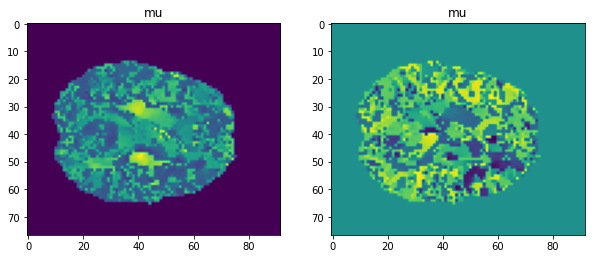

In [11]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(mu[:,:,0])
ax2.imshow(mu[:,:,1])
ax1.set_title('mu')
ax2.set_title('mu')

In [12]:
with open('SAS_stick_mu.txt', 'w') as file:
    for line in mu:
        file.write("%s\n" %line)
        
file.close()

In [13]:
import numpy as np

l_par = np.zeros((data.shape[0], data.shape[1], 2))

for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        if mask_data[x,y,30] > 0:
            fitted_SAS = sphere_and_stick.fit(acq_scheme, data[x,y,30,:])
            print(fitted_SAS.fitted_parameters['C1Stick_1_lambda_par'])
            l_par[x,y,:] = fitted_SAS.fitted_parameters['C1Stick_1_lambda_par']
            print((x, y))
            
print(l_par)

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2438199520111084 seconds
Fitting of 1 voxels complete in 0.07548379898071289 seconds.
Average of 0.07548379898071289 seconds per voxel.
[3.e-09]
(14, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2767198085784912 seconds
Fitting of 1 voxels complete in 0.0685429573059082 seconds.
Average of 0.0685429573059082 seconds per voxel.
[3.e-09]
(14, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2697322368621826 seconds
Fitting of 1 voxels complete in 0.0685727596282959 seconds.
Average of 0.0685727596282959 seconds per voxel.
[3.e-09]
(14, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.274928331375122 seconds
Fitting of 1 voxels complete in 0.06789970397949219 seconds.
Average of 0.06789970397949219 seconds per voxel.
[3.e-09]
(14, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2588131427764893 se

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2668368816375732 seconds
Fitting of 1 voxels complete in 0.06849193572998047 seconds.
Average of 0.06849193572998047 seconds per voxel.
[3.e-09]
(16, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2704482078552246 seconds
Fitting of 1 voxels complete in 0.0692589282989502 seconds.
Average of 0.0692589282989502 seconds per voxel.
[3.e-09]
(16, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2693860530853271 seconds
Fitting of 1 voxels complete in 0.07161998748779297 seconds.
Average of 0.07161998748779297 seconds per voxel.
[3.e-09]
(16, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.265476942062378 seconds
Fitting of 1 voxels complete in 0.08925175666809082 seconds.
Average of 0.08925175666809082 seconds per voxel.
[3.e-09]
(16, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.261566162109375 s

Setup brute2fine optimizer in 1.2783379554748535 seconds
Fitting of 1 voxels complete in 0.06396198272705078 seconds.
Average of 0.06396198272705078 seconds per voxel.
[3.e-09]
(18, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2752740383148193 seconds
Fitting of 1 voxels complete in 0.06202507019042969 seconds.
Average of 0.06202507019042969 seconds per voxel.
[3.e-09]
(18, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2848587036132812 seconds
Fitting of 1 voxels complete in 0.06515002250671387 seconds.
Average of 0.06515002250671387 seconds per voxel.
[3.e-09]
(18, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.280834674835205 seconds
Fitting of 1 voxels complete in 0.09936285018920898 seconds.
Average of 0.09936285018920898 seconds per voxel.
[3.e-09]
(18, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2780520915985107 seconds
Fitting of 1 voxels complete in 

Setup brute2fine optimizer in 1.2741329669952393 seconds
Fitting of 1 voxels complete in 0.06381487846374512 seconds.
Average of 0.06381487846374512 seconds per voxel.
[3.e-09]
(19, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3287339210510254 seconds
Fitting of 1 voxels complete in 0.06192183494567871 seconds.
Average of 0.06192183494567871 seconds per voxel.
[3.e-09]
(19, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.503875970840454 seconds
Fitting of 1 voxels complete in 0.06138205528259277 seconds.
Average of 0.06138205528259277 seconds per voxel.
[3.e-09]
(19, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3450849056243896 seconds
Fitting of 1 voxels complete in 0.06304287910461426 seconds.
Average of 0.06304287910461426 seconds per voxel.
[3.e-09]
(19, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3307552337646484 seconds
Fitting of 1 voxels complete in 

Setup brute2fine optimizer in 1.2728931903839111 seconds
Fitting of 1 voxels complete in 0.05661797523498535 seconds.
Average of 0.05661797523498535 seconds per voxel.
[3.e-09]
(19, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2730529308319092 seconds
Fitting of 1 voxels complete in 0.05824708938598633 seconds.
Average of 0.05824708938598633 seconds per voxel.
[3.e-09]
(20, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2803378105163574 seconds
Fitting of 1 voxels complete in 0.06098675727844238 seconds.
Average of 0.06098675727844238 seconds per voxel.
[3.e-09]
(20, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.274522066116333 seconds
Fitting of 1 voxels complete in 0.06463289260864258 seconds.
Average of 0.06463289260864258 seconds per voxel.
[3.e-09]
(20, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2845759391784668 seconds
Fitting of 1 voxels complete in 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2800917625427246 seconds
Fitting of 1 voxels complete in 0.08642292022705078 seconds.
Average of 0.08642292022705078 seconds per voxel.
[3.e-09]
(20, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3233468532562256 seconds
Fitting of 1 voxels complete in 0.0808858871459961 seconds.
Average of 0.0808858871459961 seconds per voxel.
[3.e-09]
(20, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3014411926269531 seconds
Fitting of 1 voxels complete in 0.07677006721496582 seconds.
Average of 0.07677006721496582 seconds per voxel.
[3.e-09]
(20, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.29475998878479 seconds
Fitting of 1 voxels complete in 0.06882500648498535 seconds.
Average of 0.06882500648498535 seconds per voxel.
[3.e-09]
(20, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2770967483520508 s

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.377830982208252 seconds
Fitting of 1 voxels complete in 0.08120512962341309 seconds.
Average of 0.08120512962341309 seconds per voxel.
[3.e-09]
(21, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.8976929187774658 seconds
Fitting of 1 voxels complete in 0.07401609420776367 seconds.
Average of 0.07401609420776367 seconds per voxel.
[3.e-09]
(21, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3805301189422607 seconds
Fitting of 1 voxels complete in 0.07090520858764648 seconds.
Average of 0.07090520858764648 seconds per voxel.
[3.e-09]
(21, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.9232549667358398 seconds
Fitting of 1 voxels complete in 0.07299304008483887 seconds.
Average of 0.07299304008483887 seconds per voxel.
[3.e-09]
(21, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.372220993041992

Setup brute2fine optimizer in 1.255033016204834 seconds
Fitting of 1 voxels complete in 0.06202888488769531 seconds.
Average of 0.06202888488769531 seconds per voxel.
[3.e-09]
(22, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2452101707458496 seconds
Fitting of 1 voxels complete in 0.06302165985107422 seconds.
Average of 0.06302165985107422 seconds per voxel.
[3.e-09]
(22, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2447009086608887 seconds
Fitting of 1 voxels complete in 0.06523013114929199 seconds.
Average of 0.06523013114929199 seconds per voxel.
[3.e-09]
(22, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2552640438079834 seconds
Fitting of 1 voxels complete in 0.06227302551269531 seconds.
Average of 0.06227302551269531 seconds per voxel.
[3.e-09]
(22, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2532508373260498 seconds
Fitting of 1 voxels complete in 

Setup brute2fine optimizer in 1.2392427921295166 seconds
Fitting of 1 voxels complete in 0.06200695037841797 seconds.
Average of 0.06200695037841797 seconds per voxel.
[3.e-09]
(23, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2505500316619873 seconds
Fitting of 1 voxels complete in 0.0637061595916748 seconds.
Average of 0.0637061595916748 seconds per voxel.
[3.e-09]
(23, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2434930801391602 seconds
Fitting of 1 voxels complete in 0.06207633018493652 seconds.
Average of 0.06207633018493652 seconds per voxel.
[3.e-09]
(23, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2468500137329102 seconds
Fitting of 1 voxels complete in 0.06315279006958008 seconds.
Average of 0.06315279006958008 seconds per voxel.
[3.e-09]
(23, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2405059337615967 seconds
Fitting of 1 voxels complete in 0

Setup brute2fine optimizer in 1.317107915878296 seconds
Fitting of 1 voxels complete in 0.0962371826171875 seconds.
Average of 0.0962371826171875 seconds per voxel.
[3.e-09]
(23, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2723677158355713 seconds
Fitting of 1 voxels complete in 0.06909799575805664 seconds.
Average of 0.06909799575805664 seconds per voxel.
[3.e-09]
(23, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2574551105499268 seconds
Fitting of 1 voxels complete in 0.06080484390258789 seconds.
Average of 0.06080484390258789 seconds per voxel.
[3.e-09]
(23, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2483582496643066 seconds
Fitting of 1 voxels complete in 0.05835866928100586 seconds.
Average of 0.05835866928100586 seconds per voxel.
[3.e-09]
(23, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.251708745956421 seconds
Fitting of 1 voxels complete in 0.0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2414188385009766 seconds
Fitting of 1 voxels complete in 0.06286311149597168 seconds.
Average of 0.06286311149597168 seconds per voxel.
[3.e-09]
(24, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2440578937530518 seconds
Fitting of 1 voxels complete in 0.06594181060791016 seconds.
Average of 0.06594181060791016 seconds per voxel.
[3.e-09]
(24, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.246556043624878 seconds
Fitting of 1 voxels complete in 0.05730891227722168 seconds.
Average of 0.05730891227722168 seconds per voxel.
[3.e-09]
(24, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2412033081054688 seconds
Fitting of 1 voxels complete in 0.07826113700866699 seconds.
Average of 0.07826113700866699 seconds per voxel.
[3.e-09]
(24, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.243484258651733

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2558560371398926 seconds
Fitting of 1 voxels complete in 0.06220698356628418 seconds.
Average of 0.06220698356628418 seconds per voxel.
[3.e-09]
(25, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2824950218200684 seconds
Fitting of 1 voxels complete in 0.0631108283996582 seconds.
Average of 0.0631108283996582 seconds per voxel.
[3.e-09]
(25, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.268603801727295 seconds
Fitting of 1 voxels complete in 0.0723111629486084 seconds.
Average of 0.0723111629486084 seconds per voxel.
[3.e-09]
(25, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2530879974365234 seconds
Fitting of 1 voxels complete in 0.06356096267700195 seconds.
Average of 0.06356096267700195 seconds per voxel.
[3.e-09]
(25, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2495207786560059 se

Setup brute2fine optimizer in 1.4799087047576904 seconds
Fitting of 1 voxels complete in 0.06247401237487793 seconds.
Average of 0.06247401237487793 seconds per voxel.
[3.e-09]
(25, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5339007377624512 seconds
Fitting of 1 voxels complete in 0.06694674491882324 seconds.
Average of 0.06694674491882324 seconds per voxel.
[3.e-09]
(25, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.5129811763763428 seconds
Fitting of 1 voxels complete in 0.15392303466796875 seconds.
Average of 0.15392303466796875 seconds per voxel.
[3.e-09]
(25, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 5.03027081489563 seconds
Fitting of 1 voxels complete in 0.07141518592834473 seconds.
Average of 0.07141518592834473 seconds per voxel.
[3.e-09]
(25, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4983181953430176 seconds
Fitting of 1 voxels complete in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.244732141494751 seconds
Fitting of 1 voxels complete in 0.15147113800048828 seconds.
Average of 0.15147113800048828 seconds per voxel.
[3.e-09]
(26, 34)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5488970279693604 seconds
Fitting of 1 voxels complete in 0.13553595542907715 seconds.
Average of 0.13553595542907715 seconds per voxel.
[3.e-09]
(26, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3939001560211182 seconds
Fitting of 1 voxels complete in 0.09949684143066406 seconds.
Average of 0.09949684143066406 seconds per voxel.
[3.e-09]
(26, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.360701084136963 seconds
Fitting of 1 voxels complete in 0.06839203834533691 seconds.
Average of 0.06839203834533691 seconds per voxel.
[3.e-09]
(26, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.9584357738494873

Setup brute2fine optimizer in 1.374089002609253 seconds
Fitting of 1 voxels complete in 0.07982325553894043 seconds.
Average of 0.07982325553894043 seconds per voxel.
[3.e-09]
(26, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2383911609649658 seconds
Fitting of 1 voxels complete in 0.0667731761932373 seconds.
Average of 0.0667731761932373 seconds per voxel.
[3.e-09]
(27, 12)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3209729194641113 seconds
Fitting of 1 voxels complete in 0.08635210990905762 seconds.
Average of 0.08635210990905762 seconds per voxel.
[3.e-09]
(27, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4580399990081787 seconds
Fitting of 1 voxels complete in 0.1082313060760498 seconds.
Average of 0.1082313060760498 seconds per voxel.
[3.e-09]
(27, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4788341522216797 seconds
Fitting of 1 voxels complete in 0.06

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3576068878173828 seconds
Fitting of 1 voxels complete in 0.06647086143493652 seconds.
Average of 0.06647086143493652 seconds per voxel.
[3.e-09]
(27, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.696281909942627 seconds
Fitting of 1 voxels complete in 0.11170196533203125 seconds.
Average of 0.11170196533203125 seconds per voxel.
[3.e-09]
(27, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.8401908874511719 seconds
Fitting of 1 voxels complete in 0.10089993476867676 seconds.
Average of 0.10089993476867676 seconds per voxel.
[3.e-09]
(27, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5900137424468994 seconds
Fitting of 1 voxels complete in 0.06972789764404297 seconds.
Average of 0.06972789764404297 seconds per voxel.
[3.e-09]
(27, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.361822843551635

Setup brute2fine optimizer in 1.9731431007385254 seconds
Fitting of 1 voxels complete in 0.0702967643737793 seconds.
Average of 0.0702967643737793 seconds per voxel.
[3.e-09]
(28, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6801409721374512 seconds
Fitting of 1 voxels complete in 0.07427978515625 seconds.
Average of 0.07427978515625 seconds per voxel.
[3.e-09]
(28, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5433409214019775 seconds
Fitting of 1 voxels complete in 0.07630586624145508 seconds.
Average of 0.07630586624145508 seconds per voxel.
[3.e-09]
(28, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2645471096038818 seconds
Fitting of 1 voxels complete in 0.06668996810913086 seconds.
Average of 0.06668996810913086 seconds per voxel.
[3.e-09]
(28, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.262251615524292 seconds
Fitting of 1 voxels complete in 0.068272

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6127328872680664 seconds
Fitting of 1 voxels complete in 0.06967806816101074 seconds.
Average of 0.06967806816101074 seconds per voxel.
[3.e-09]
(28, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5769169330596924 seconds
Fitting of 1 voxels complete in 0.10069704055786133 seconds.
Average of 0.10069704055786133 seconds per voxel.
[3.e-09]
(28, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5564651489257812 seconds
Fitting of 1 voxels complete in 0.08206605911254883 seconds.
Average of 0.08206605911254883 seconds per voxel.
[3.e-09]
(28, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.95369815826416 seconds
Fitting of 1 voxels complete in 0.07810807228088379 seconds.
Average of 0.07810807228088379 seconds per voxel.
[3.e-09]
(28, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.9081921577453613

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2306969165802002 seconds
Fitting of 1 voxels complete in 0.06324243545532227 seconds.
Average of 0.06324243545532227 seconds per voxel.
[3.e-09]
(29, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2898039817810059 seconds
Fitting of 1 voxels complete in 0.0723116397857666 seconds.
Average of 0.0723116397857666 seconds per voxel.
[3.e-09]
(29, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2612390518188477 seconds
Fitting of 1 voxels complete in 0.05884599685668945 seconds.
Average of 0.05884599685668945 seconds per voxel.
[3.e-09]
(29, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2347431182861328 seconds
Fitting of 1 voxels complete in 0.06624197959899902 seconds.
Average of 0.06624197959899902 seconds per voxel.
[3.e-09]
(29, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.1737139225006104

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3896028995513916 seconds
Fitting of 1 voxels complete in 0.07809305191040039 seconds.
Average of 0.07809305191040039 seconds per voxel.
[3.e-09]
(30, 10)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.474992275238037 seconds
Fitting of 1 voxels complete in 0.09859585762023926 seconds.
Average of 0.09859585762023926 seconds per voxel.
[3.e-09]
(30, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.232797384262085 seconds
Fitting of 1 voxels complete in 0.06141996383666992 seconds.
Average of 0.06141996383666992 seconds per voxel.
[3.e-09]
(30, 12)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2346320152282715 seconds
Fitting of 1 voxels complete in 0.06926822662353516 seconds.
Average of 0.06926822662353516 seconds per voxel.
[3.e-09]
(30, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2514839172363281

Setup brute2fine optimizer in 1.330024003982544 seconds
Fitting of 1 voxels complete in 0.06395292282104492 seconds.
Average of 0.06395292282104492 seconds per voxel.
[3.e-09]
(30, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.250195026397705 seconds
Fitting of 1 voxels complete in 0.07007598876953125 seconds.
Average of 0.07007598876953125 seconds per voxel.
[3.e-09]
(30, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.235826015472412 seconds
Fitting of 1 voxels complete in 0.06762504577636719 seconds.
Average of 0.06762504577636719 seconds per voxel.
[3.e-09]
(30, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.31382417678833 seconds
Fitting of 1 voxels complete in 0.0697317123413086 seconds.
Average of 0.0697317123413086 seconds per voxel.
[3.e-09]
(30, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2519090175628662 seconds
Fitting of 1 voxels complete in 0.0748

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.552889108657837 seconds
Fitting of 1 voxels complete in 0.06459689140319824 seconds.
Average of 0.06459689140319824 seconds per voxel.
[3.e-09]
(31, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2846698760986328 seconds
Fitting of 1 voxels complete in 0.07129693031311035 seconds.
Average of 0.07129693031311035 seconds per voxel.
[3.e-09]
(31, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.313154935836792 seconds
Fitting of 1 voxels complete in 0.06930112838745117 seconds.
Average of 0.06930112838745117 seconds per voxel.
[3.e-09]
(31, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.037087917327881 seconds
Fitting of 1 voxels complete in 0.08477163314819336 seconds.
Average of 0.08477163314819336 seconds per voxel.
[3.e-09]
(31, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5169589519500732 

Setup brute2fine optimizer in 2.3421287536621094 seconds
Fitting of 1 voxels complete in 0.06851482391357422 seconds.
Average of 0.06851482391357422 seconds per voxel.
[3.e-09]
(31, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3257920742034912 seconds
Fitting of 1 voxels complete in 0.06106996536254883 seconds.
Average of 0.06106996536254883 seconds per voxel.
[3.e-09]
(31, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.302663803100586 seconds
Fitting of 1 voxels complete in 0.09485530853271484 seconds.
Average of 0.09485530853271484 seconds per voxel.
[3.e-09]
(31, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3433890342712402 seconds
Fitting of 1 voxels complete in 0.07256078720092773 seconds.
Average of 0.07256078720092773 seconds per voxel.
[3.e-09]
(31, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.375885009765625 seconds
Fitting of 1 voxels complete in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5577118396759033 seconds
Fitting of 1 voxels complete in 0.07676482200622559 seconds.
Average of 0.07676482200622559 seconds per voxel.
[3.e-09]
(32, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.505906105041504 seconds
Fitting of 1 voxels complete in 0.0811150074005127 seconds.
Average of 0.0811150074005127 seconds per voxel.
[3.e-09]
(32, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3579752445220947 seconds
Fitting of 1 voxels complete in 0.06147027015686035 seconds.
Average of 0.06147027015686035 seconds per voxel.
[3.e-09]
(32, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.394901990890503 seconds
Fitting of 1 voxels complete in 0.0674281120300293 seconds.
Average of 0.0674281120300293 seconds per voxel.
[3.e-09]
(32, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.356645107269287 seco

Setup brute2fine optimizer in 1.8365249633789062 seconds
Fitting of 1 voxels complete in 0.1653449535369873 seconds.
Average of 0.1653449535369873 seconds per voxel.
[3.e-09]
(32, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.7948431968688965 seconds
Fitting of 1 voxels complete in 0.11486220359802246 seconds.
Average of 0.11486220359802246 seconds per voxel.
[3.e-09]
(32, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.542931079864502 seconds
Fitting of 1 voxels complete in 0.06119203567504883 seconds.
Average of 0.06119203567504883 seconds per voxel.
[3.e-09]
(32, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.8290627002716064 seconds
Fitting of 1 voxels complete in 0.05768013000488281 seconds.
Average of 0.05768013000488281 seconds per voxel.
[3.e-09]
(32, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5772197246551514 seconds
Fitting of 1 voxels complete in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2775030136108398 seconds
Fitting of 1 voxels complete in 0.06457400321960449 seconds.
Average of 0.06457400321960449 seconds per voxel.
[3.e-09]
(33, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2437419891357422 seconds
Fitting of 1 voxels complete in 0.09795188903808594 seconds.
Average of 0.09795188903808594 seconds per voxel.
[3.e-09]
(33, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3458302021026611 seconds
Fitting of 1 voxels complete in 0.07490730285644531 seconds.
Average of 0.07490730285644531 seconds per voxel.
[3.e-09]
(33, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3449749946594238 seconds
Fitting of 1 voxels complete in 0.08067917823791504 seconds.
Average of 0.08067917823791504 seconds per voxel.
[3.e-09]
(33, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.40476083755493

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.28106689453125 seconds
Fitting of 1 voxels complete in 0.06218981742858887 seconds.
Average of 0.06218981742858887 seconds per voxel.
[3.e-09]
(33, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3166210651397705 seconds
Fitting of 1 voxels complete in 0.06881904602050781 seconds.
Average of 0.06881904602050781 seconds per voxel.
[3.e-09]
(33, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3056929111480713 seconds
Fitting of 1 voxels complete in 0.06386494636535645 seconds.
Average of 0.06386494636535645 seconds per voxel.
[3.e-09]
(33, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2310450077056885 seconds
Fitting of 1 voxels complete in 0.09293007850646973 seconds.
Average of 0.09293007850646973 seconds per voxel.
[3.e-09]
(33, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2660539150238037

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2261028289794922 seconds
Fitting of 1 voxels complete in 0.06253910064697266 seconds.
Average of 0.06253910064697266 seconds per voxel.
[3.e-09]
(34, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2475237846374512 seconds
Fitting of 1 voxels complete in 0.06443285942077637 seconds.
Average of 0.06443285942077637 seconds per voxel.
[3.e-09]
(34, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2577829360961914 seconds
Fitting of 1 voxels complete in 0.06330680847167969 seconds.
Average of 0.06330680847167969 seconds per voxel.
[3.e-09]
(34, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2485160827636719 seconds
Fitting of 1 voxels complete in 0.06837129592895508 seconds.
Average of 0.06837129592895508 seconds per voxel.
[3.e-09]
(34, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.24836707115173

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2394843101501465 seconds
Fitting of 1 voxels complete in 0.0690450668334961 seconds.
Average of 0.0690450668334961 seconds per voxel.
[3.e-09]
(35, 12)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.228623867034912 seconds
Fitting of 1 voxels complete in 0.06275486946105957 seconds.
Average of 0.06275486946105957 seconds per voxel.
[3.e-09]
(35, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2323460578918457 seconds
Fitting of 1 voxels complete in 0.06069517135620117 seconds.
Average of 0.06069517135620117 seconds per voxel.
[3.e-09]
(35, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2298779487609863 seconds
Fitting of 1 voxels complete in 0.0627899169921875 seconds.
Average of 0.0627899169921875 seconds per voxel.
[3.e-09]
(35, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2506120204925537 se

Setup brute2fine optimizer in 1.2301712036132812 seconds
Fitting of 1 voxels complete in 0.05889415740966797 seconds.
Average of 0.05889415740966797 seconds per voxel.
[3.e-09]
(35, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2290921211242676 seconds
Fitting of 1 voxels complete in 0.05856919288635254 seconds.
Average of 0.05856919288635254 seconds per voxel.
[3.e-09]
(35, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2871410846710205 seconds
Fitting of 1 voxels complete in 0.059229135513305664 seconds.
Average of 0.059229135513305664 seconds per voxel.
[3.e-09]
(35, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2248790264129639 seconds
Fitting of 1 voxels complete in 0.06308197975158691 seconds.
Average of 0.06308197975158691 seconds per voxel.
[3.e-09]
(35, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2439658641815186 seconds
Fitting of 1 voxels complete 

Setup brute2fine optimizer in 1.9067330360412598 seconds
Fitting of 1 voxels complete in 0.06857824325561523 seconds.
Average of 0.06857824325561523 seconds per voxel.
[3.e-09]
(36, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6310477256774902 seconds
Fitting of 1 voxels complete in 0.061676025390625 seconds.
Average of 0.061676025390625 seconds per voxel.
[3.e-09]
(36, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4716761112213135 seconds
Fitting of 1 voxels complete in 0.10614705085754395 seconds.
Average of 0.10614705085754395 seconds per voxel.
[3.e-09]
(36, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5756769180297852 seconds
Fitting of 1 voxels complete in 0.07095718383789062 seconds.
Average of 0.07095718383789062 seconds per voxel.
[3.e-09]
(36, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5958101749420166 seconds
Fitting of 1 voxels complete in 0.0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7274479866027832 seconds
Fitting of 1 voxels complete in 0.20099925994873047 seconds.
Average of 0.20099925994873047 seconds per voxel.
[3.e-09]
(36, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.2961819171905518 seconds
Fitting of 1 voxels complete in 0.08279824256896973 seconds.
Average of 0.08279824256896973 seconds per voxel.
[3.e-09]
(36, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.475680112838745 seconds
Fitting of 1 voxels complete in 0.07634305953979492 seconds.
Average of 0.07634305953979492 seconds per voxel.
[3.e-09]
(36, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7761709690093994 seconds
Fitting of 1 voxels complete in 0.06596708297729492 seconds.
Average of 0.06596708297729492 seconds per voxel.
[3.e-09]
(36, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.535364151000976

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3313748836517334 seconds
Fitting of 1 voxels complete in 0.06941008567810059 seconds.
Average of 0.06941008567810059 seconds per voxel.
[3.e-09]
(37, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2445769309997559 seconds
Fitting of 1 voxels complete in 0.07489991188049316 seconds.
Average of 0.07489991188049316 seconds per voxel.
[3.e-09]
(37, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7290117740631104 seconds
Fitting of 1 voxels complete in 0.06333613395690918 seconds.
Average of 0.06333613395690918 seconds per voxel.
[3.e-09]
(37, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3380999565124512 seconds
Fitting of 1 voxels complete in 0.06000518798828125 seconds.
Average of 0.06000518798828125 seconds per voxel.
[3.e-09]
(37, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.31001305580139

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3331470489501953 seconds
Fitting of 1 voxels complete in 0.07052111625671387 seconds.
Average of 0.07052111625671387 seconds per voxel.
[3.e-09]
(37, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3672780990600586 seconds
Fitting of 1 voxels complete in 0.07581329345703125 seconds.
Average of 0.07581329345703125 seconds per voxel.
[3.e-09]
(37, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4382960796356201 seconds
Fitting of 1 voxels complete in 0.07588720321655273 seconds.
Average of 0.07588720321655273 seconds per voxel.
[3.e-09]
(37, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7015881538391113 seconds
Fitting of 1 voxels complete in 0.07097506523132324 seconds.
Average of 0.07097506523132324 seconds per voxel.
[3.e-09]
(37, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.45903205871582

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2316510677337646 seconds
Fitting of 1 voxels complete in 0.05862593650817871 seconds.
Average of 0.05862593650817871 seconds per voxel.
[3.e-09]
(38, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2304491996765137 seconds
Fitting of 1 voxels complete in 0.05876803398132324 seconds.
Average of 0.05876803398132324 seconds per voxel.
[3.e-09]
(38, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2313361167907715 seconds
Fitting of 1 voxels complete in 0.06866097450256348 seconds.
Average of 0.06866097450256348 seconds per voxel.
[3.e-09]
(38, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2335128784179688 seconds
Fitting of 1 voxels complete in 0.06126880645751953 seconds.
Average of 0.06126880645751953 seconds per voxel.
[3.e-09]
(38, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.22863411903381

Setup brute2fine optimizer in 1.570728063583374 seconds
Fitting of 1 voxels complete in 0.08511686325073242 seconds.
Average of 0.08511686325073242 seconds per voxel.
[3.e-09]
(38, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4615540504455566 seconds
Fitting of 1 voxels complete in 0.0718851089477539 seconds.
Average of 0.0718851089477539 seconds per voxel.
[3.e-09]
(38, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5619752407073975 seconds
Fitting of 1 voxels complete in 0.07153987884521484 seconds.
Average of 0.07153987884521484 seconds per voxel.
[3.e-09]
(38, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4277472496032715 seconds
Fitting of 1 voxels complete in 0.07126903533935547 seconds.
Average of 0.07126903533935547 seconds per voxel.
[3.e-09]
(39, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5344820022583008 seconds
Fitting of 1 voxels complete in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.502135992050171 seconds
Fitting of 1 voxels complete in 0.06739687919616699 seconds.
Average of 0.06739687919616699 seconds per voxel.
[3.e-09]
(39, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4402260780334473 seconds
Fitting of 1 voxels complete in 0.062172889709472656 seconds.
Average of 0.062172889709472656 seconds per voxel.
[3.e-09]
(39, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4978411197662354 seconds
Fitting of 1 voxels complete in 0.08515787124633789 seconds.
Average of 0.08515787124633789 seconds per voxel.
[3.e-09]
(39, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7388858795166016 seconds
Fitting of 1 voxels complete in 0.10047173500061035 seconds.
Average of 0.10047173500061035 seconds per voxel.
[3.e-09]
(39, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4503901004791

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3283839225769043 seconds
Fitting of 1 voxels complete in 0.06606292724609375 seconds.
Average of 0.06606292724609375 seconds per voxel.
[3.e-09]
(40, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.337589979171753 seconds
Fitting of 1 voxels complete in 0.06673097610473633 seconds.
Average of 0.06673097610473633 seconds per voxel.
[3.e-09]
(40, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3809630870819092 seconds
Fitting of 1 voxels complete in 0.07173705101013184 seconds.
Average of 0.07173705101013184 seconds per voxel.
[3.e-09]
(40, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.294043779373169 seconds
Fitting of 1 voxels complete in 0.0562441349029541 seconds.
Average of 0.0562441349029541 seconds per voxel.
[3.e-09]
(40, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4787230491638184 s

Setup brute2fine optimizer in 1.3569228649139404 seconds
Fitting of 1 voxels complete in 0.06411290168762207 seconds.
Average of 0.06411290168762207 seconds per voxel.
[3.e-09]
(40, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2400398254394531 seconds
Fitting of 1 voxels complete in 0.057274818420410156 seconds.
Average of 0.057274818420410156 seconds per voxel.
[3.e-09]
(40, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4473190307617188 seconds
Fitting of 1 voxels complete in 0.06392288208007812 seconds.
Average of 0.06392288208007812 seconds per voxel.
[3.e-09]
(40, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.9921579360961914 seconds
Fitting of 1 voxels complete in 0.1123509407043457 seconds.
Average of 0.1123509407043457 seconds per voxel.
[3.e-09]
(40, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.4980881214141846 seconds
Fitting of 1 voxels complete in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4386789798736572 seconds
Fitting of 1 voxels complete in 0.06665396690368652 seconds.
Average of 0.06665396690368652 seconds per voxel.
[3.e-09]
(41, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3336260318756104 seconds
Fitting of 1 voxels complete in 0.06589913368225098 seconds.
Average of 0.06589913368225098 seconds per voxel.
[3.e-09]
(41, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2924342155456543 seconds
Fitting of 1 voxels complete in 0.06609487533569336 seconds.
Average of 0.06609487533569336 seconds per voxel.
[3.e-09]
(41, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3882150650024414 seconds
Fitting of 1 voxels complete in 0.062387943267822266 seconds.
Average of 0.062387943267822266 seconds per voxel.
[3.e-09]
(41, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.268059015274

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3798258304595947 seconds
Fitting of 1 voxels complete in 0.061929941177368164 seconds.
Average of 0.061929941177368164 seconds per voxel.
[3.e-09]
(41, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.244520902633667 seconds
Fitting of 1 voxels complete in 0.0681450366973877 seconds.
Average of 0.0681450366973877 seconds per voxel.
[3.e-09]
(41, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.355846881866455 seconds
Fitting of 1 voxels complete in 0.06447601318359375 seconds.
Average of 0.06447601318359375 seconds per voxel.
[3.e-09]
(41, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.235781192779541 seconds
Fitting of 1 voxels complete in 0.05637788772583008 seconds.
Average of 0.05637788772583008 seconds per voxel.
[3.e-09]
(41, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2518517971038818 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3243467807769775 seconds
Fitting of 1 voxels complete in 0.05828142166137695 seconds.
Average of 0.05828142166137695 seconds per voxel.
[3.e-09]
(42, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.440906047821045 seconds
Fitting of 1 voxels complete in 0.06631708145141602 seconds.
Average of 0.06631708145141602 seconds per voxel.
[3.e-09]
(42, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.354203224182129 seconds
Fitting of 1 voxels complete in 0.0599970817565918 seconds.
Average of 0.0599970817565918 seconds per voxel.
[3.e-09]
(42, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3419520854949951 seconds
Fitting of 1 voxels complete in 0.0652318000793457 seconds.
Average of 0.0652318000793457 seconds per voxel.
[3.e-09]
(42, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5595769882202148 sec

Setup brute2fine optimizer in 1.5858078002929688 seconds
Fitting of 1 voxels complete in 0.055991172790527344 seconds.
Average of 0.055991172790527344 seconds per voxel.
[3.e-09]
(43, 11)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2525851726531982 seconds
Fitting of 1 voxels complete in 0.07357001304626465 seconds.
Average of 0.07357001304626465 seconds per voxel.
[3.e-09]
(43, 12)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3665640354156494 seconds
Fitting of 1 voxels complete in 0.06472182273864746 seconds.
Average of 0.06472182273864746 seconds per voxel.
[3.e-09]
(43, 13)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4127962589263916 seconds
Fitting of 1 voxels complete in 0.0669708251953125 seconds.
Average of 0.0669708251953125 seconds per voxel.
[3.e-09]
(43, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3925588130950928 seconds
Fitting of 1 voxels complete in

Setup brute2fine optimizer in 1.291867971420288 seconds
Fitting of 1 voxels complete in 0.07631802558898926 seconds.
Average of 0.07631802558898926 seconds per voxel.
[3.e-09]
(43, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3765051364898682 seconds
Fitting of 1 voxels complete in 0.07763886451721191 seconds.
Average of 0.07763886451721191 seconds per voxel.
[3.e-09]
(43, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7066550254821777 seconds
Fitting of 1 voxels complete in 0.06407999992370605 seconds.
Average of 0.06407999992370605 seconds per voxel.
[3.e-09]
(43, 49)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5389759540557861 seconds
Fitting of 1 voxels complete in 0.07394981384277344 seconds.
Average of 0.07394981384277344 seconds per voxel.
[3.e-09]
(43, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.39683198928833 seconds
Fitting of 1 voxels complete in 0.

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3968441486358643 seconds
Fitting of 1 voxels complete in 0.0719301700592041 seconds.
Average of 0.0719301700592041 seconds per voxel.
[3.e-09]
(44, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3434209823608398 seconds
Fitting of 1 voxels complete in 0.06145191192626953 seconds.
Average of 0.06145191192626953 seconds per voxel.
[3.e-09]
(44, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4305479526519775 seconds
Fitting of 1 voxels complete in 0.06068563461303711 seconds.
Average of 0.06068563461303711 seconds per voxel.
[3.e-09]
(44, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5718839168548584 seconds
Fitting of 1 voxels complete in 0.0740511417388916 seconds.
Average of 0.0740511417388916 seconds per voxel.
[3.e-09]
(44, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3987689018249512 s

Setup brute2fine optimizer in 1.3435628414154053 seconds
Fitting of 1 voxels complete in 0.06764578819274902 seconds.
Average of 0.06764578819274902 seconds per voxel.
[3.e-09]
(44, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3095431327819824 seconds
Fitting of 1 voxels complete in 0.06767606735229492 seconds.
Average of 0.06767606735229492 seconds per voxel.
[3.e-09]
(44, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2769410610198975 seconds
Fitting of 1 voxels complete in 0.05945587158203125 seconds.
Average of 0.05945587158203125 seconds per voxel.
[3.e-09]
(44, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3126089572906494 seconds
Fitting of 1 voxels complete in 0.0667121410369873 seconds.
Average of 0.0667121410369873 seconds per voxel.
[3.e-09]
(44, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4204909801483154 seconds
Fitting of 1 voxels complete in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.8791401386260986 seconds
Fitting of 1 voxels complete in 0.07986617088317871 seconds.
Average of 0.07986617088317871 seconds per voxel.
[3.e-09]
(45, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7122130393981934 seconds
Fitting of 1 voxels complete in 0.06827402114868164 seconds.
Average of 0.06827402114868164 seconds per voxel.
[3.e-09]
(45, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4638748168945312 seconds
Fitting of 1 voxels complete in 0.066925048828125 seconds.
Average of 0.066925048828125 seconds per voxel.
[3.e-09]
(45, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4423820972442627 seconds
Fitting of 1 voxels complete in 0.061382293701171875 seconds.
Average of 0.061382293701171875 seconds per voxel.
[3.e-09]
(45, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3600151538848877

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4461679458618164 seconds
Fitting of 1 voxels complete in 0.07498788833618164 seconds.
Average of 0.07498788833618164 seconds per voxel.
[3.e-09]
(45, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.421294927597046 seconds
Fitting of 1 voxels complete in 0.075592041015625 seconds.
Average of 0.075592041015625 seconds per voxel.
[3.e-09]
(45, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4172499179840088 seconds
Fitting of 1 voxels complete in 0.07080388069152832 seconds.
Average of 0.07080388069152832 seconds per voxel.
[3.e-09]
(45, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4514360427856445 seconds
Fitting of 1 voxels complete in 0.06910586357116699 seconds.
Average of 0.06910586357116699 seconds per voxel.
[3.e-09]
(45, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3352899551391602 se

Setup brute2fine optimizer in 1.5993421077728271 seconds
Fitting of 1 voxels complete in 0.06806087493896484 seconds.
Average of 0.06806087493896484 seconds per voxel.
[3.e-09]
(46, 35)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5245041847229004 seconds
Fitting of 1 voxels complete in 0.07992792129516602 seconds.
Average of 0.07992792129516602 seconds per voxel.
[3.e-09]
(46, 36)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3966751098632812 seconds
Fitting of 1 voxels complete in 0.06615686416625977 seconds.
Average of 0.06615686416625977 seconds per voxel.
[3.e-09]
(46, 37)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.342698097229004 seconds
Fitting of 1 voxels complete in 0.06152701377868652 seconds.
Average of 0.06152701377868652 seconds per voxel.
[3.e-09]
(46, 38)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.435276985168457 seconds
Fitting of 1 voxels complete in 0

Setup brute2fine optimizer in 1.5098490715026855 seconds
Fitting of 1 voxels complete in 0.06852316856384277 seconds.
Average of 0.06852316856384277 seconds per voxel.
[3.e-09]
(46, 71)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4531540870666504 seconds
Fitting of 1 voxels complete in 0.06773018836975098 seconds.
Average of 0.06773018836975098 seconds per voxel.
[3.e-09]
(46, 72)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4808011054992676 seconds
Fitting of 1 voxels complete in 0.08179998397827148 seconds.
Average of 0.08179998397827148 seconds per voxel.
[3.e-09]
(46, 73)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5142967700958252 seconds
Fitting of 1 voxels complete in 0.07261896133422852 seconds.
Average of 0.07261896133422852 seconds per voxel.
[3.e-09]
(46, 74)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4687657356262207 seconds
Fitting of 1 voxels complete in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3566339015960693 seconds
Fitting of 1 voxels complete in 0.07090306282043457 seconds.
Average of 0.07090306282043457 seconds per voxel.
[3.e-09]
(47, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4647331237792969 seconds
Fitting of 1 voxels complete in 0.0693979263305664 seconds.
Average of 0.0693979263305664 seconds per voxel.
[3.e-09]
(47, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4273700714111328 seconds
Fitting of 1 voxels complete in 0.07110714912414551 seconds.
Average of 0.07110714912414551 seconds per voxel.
[3.e-09]
(47, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5480430126190186 seconds
Fitting of 1 voxels complete in 0.06975269317626953 seconds.
Average of 0.06975269317626953 seconds per voxel.
[3.e-09]
(47, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.507782220840454 

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.407465934753418 seconds
Fitting of 1 voxels complete in 0.05982804298400879 seconds.
Average of 0.05982804298400879 seconds per voxel.
[3.e-09]
(48, 14)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3765912055969238 seconds
Fitting of 1 voxels complete in 0.06884503364562988 seconds.
Average of 0.06884503364562988 seconds per voxel.
[3.e-09]
(48, 15)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.400136947631836 seconds
Fitting of 1 voxels complete in 0.06373786926269531 seconds.
Average of 0.06373786926269531 seconds per voxel.
[3.e-09]
(48, 16)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3748300075531006 seconds
Fitting of 1 voxels complete in 0.06804466247558594 seconds.
Average of 0.06804466247558594 seconds per voxel.
[3.e-09]
(48, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.317136287689209 

Setup brute2fine optimizer in 2.5350027084350586 seconds
Fitting of 1 voxels complete in 0.12781786918640137 seconds.
Average of 0.12781786918640137 seconds per voxel.
[3.e-09]
(48, 50)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.666969060897827 seconds
Fitting of 1 voxels complete in 0.070343017578125 seconds.
Average of 0.070343017578125 seconds per voxel.
[3.e-09]
(48, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.531067132949829 seconds
Fitting of 1 voxels complete in 0.06663799285888672 seconds.
Average of 0.06663799285888672 seconds per voxel.
[3.e-09]
(48, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6462681293487549 seconds
Fitting of 1 voxels complete in 0.06673693656921387 seconds.
Average of 0.06673693656921387 seconds per voxel.
[3.e-09]
(48, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5924301147460938 seconds
Fitting of 1 voxels complete in 0.077

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.636828899383545 seconds
Fitting of 1 voxels complete in 0.07980108261108398 seconds.
Average of 0.07980108261108398 seconds per voxel.
[3.e-09]
(49, 21)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6451470851898193 seconds
Fitting of 1 voxels complete in 0.08098888397216797 seconds.
Average of 0.08098888397216797 seconds per voxel.
[3.e-09]
(49, 22)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6572520732879639 seconds
Fitting of 1 voxels complete in 0.08188176155090332 seconds.
Average of 0.08188176155090332 seconds per voxel.
[3.e-09]
(49, 23)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.668743371963501 seconds
Fitting of 1 voxels complete in 0.1000361442565918 seconds.
Average of 0.1000361442565918 seconds per voxel.
[3.e-09]
(49, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7933650016784668 s

Setup brute2fine optimizer in 1.6125280857086182 seconds
Fitting of 1 voxels complete in 0.07256126403808594 seconds.
Average of 0.07256126403808594 seconds per voxel.
[3.e-09]
(49, 57)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.9294700622558594 seconds
Fitting of 1 voxels complete in 0.07871890068054199 seconds.
Average of 0.07871890068054199 seconds per voxel.
[3.e-09]
(49, 58)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2549731731414795 seconds
Fitting of 1 voxels complete in 0.0627129077911377 seconds.
Average of 0.0627129077911377 seconds per voxel.
[3.e-09]
(49, 59)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2771358489990234 seconds
Fitting of 1 voxels complete in 0.08736610412597656 seconds.
Average of 0.08736610412597656 seconds per voxel.
[3.e-09]
(49, 60)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2565069198608398 seconds
Fitting of 1 voxels complete in 0

Setup brute2fine optimizer in 1.2885770797729492 seconds
Fitting of 1 voxels complete in 0.07258796691894531 seconds.
Average of 0.07258796691894531 seconds per voxel.
[3.e-09]
(50, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2863543033599854 seconds
Fitting of 1 voxels complete in 0.07134890556335449 seconds.
Average of 0.07134890556335449 seconds per voxel.
[3.e-09]
(50, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.27583909034729 seconds
Fitting of 1 voxels complete in 0.06681132316589355 seconds.
Average of 0.06681132316589355 seconds per voxel.
[3.e-09]
(50, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5305728912353516 seconds
Fitting of 1 voxels complete in 0.07657217979431152 seconds.
Average of 0.07657217979431152 seconds per voxel.
[3.e-09]
(50, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7579562664031982 seconds
Fitting of 1 voxels complete in 0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.0383799076080322 seconds
Fitting of 1 voxels complete in 0.2177410125732422 seconds.
Average of 0.2177410125732422 seconds per voxel.
[3.e-09]
(50, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.5201590061187744 seconds
Fitting of 1 voxels complete in 0.07548332214355469 seconds.
Average of 0.07548332214355469 seconds per voxel.
[3.e-09]
(50, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4493529796600342 seconds
Fitting of 1 voxels complete in 0.07980918884277344 seconds.
Average of 0.07980918884277344 seconds per voxel.
[3.e-09]
(50, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4879400730133057 seconds
Fitting of 1 voxels complete in 0.08547711372375488 seconds.
Average of 0.08547711372375488 seconds per voxel.
[3.e-09]
(50, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4212639331817627

Setup brute2fine optimizer in 1.437913179397583 seconds
Fitting of 1 voxels complete in 0.06425023078918457 seconds.
Average of 0.06425023078918457 seconds per voxel.
[3.e-09]
(51, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4176390171051025 seconds
Fitting of 1 voxels complete in 0.0779259204864502 seconds.
Average of 0.0779259204864502 seconds per voxel.
[3.e-09]
(51, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.267906665802002 seconds
Fitting of 1 voxels complete in 0.08642983436584473 seconds.
Average of 0.08642983436584473 seconds per voxel.
[3.e-09]
(51, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2603790760040283 seconds
Fitting of 1 voxels complete in 0.08408379554748535 seconds.
Average of 0.08408379554748535 seconds per voxel.
[3.e-09]
(51, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3669328689575195 seconds
Fitting of 1 voxels complete in 0.0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4321129322052002 seconds
Fitting of 1 voxels complete in 0.07514023780822754 seconds.
Average of 0.07514023780822754 seconds per voxel.
[3.e-09]
(52, 17)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4558207988739014 seconds
Fitting of 1 voxels complete in 0.06639409065246582 seconds.
Average of 0.06639409065246582 seconds per voxel.
[3.e-09]
(52, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.551063060760498 seconds
Fitting of 1 voxels complete in 0.06883621215820312 seconds.
Average of 0.06883621215820312 seconds per voxel.
[3.e-09]
(52, 19)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6346287727355957 seconds
Fitting of 1 voxels complete in 0.14415812492370605 seconds.
Average of 0.14415812492370605 seconds per voxel.
[3.e-09]
(52, 20)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.344797849655151

Setup brute2fine optimizer in 1.5959999561309814 seconds
Fitting of 1 voxels complete in 0.10250687599182129 seconds.
Average of 0.10250687599182129 seconds per voxel.
[3.e-09]
(52, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4565649032592773 seconds
Fitting of 1 voxels complete in 0.07553410530090332 seconds.
Average of 0.07553410530090332 seconds per voxel.
[3.e-09]
(52, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4259529113769531 seconds
Fitting of 1 voxels complete in 0.07248091697692871 seconds.
Average of 0.07248091697692871 seconds per voxel.
[3.e-09]
(52, 55)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.421142816543579 seconds
Fitting of 1 voxels complete in 0.07419681549072266 seconds.
Average of 0.07419681549072266 seconds per voxel.
[3.e-09]
(52, 56)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4185388088226318 seconds
Fitting of 1 voxels complete in 

Setup brute2fine optimizer in 1.5430350303649902 seconds
Fitting of 1 voxels complete in 0.07676482200622559 seconds.
Average of 0.07676482200622559 seconds per voxel.
[3.e-09]
(53, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.420339822769165 seconds
Fitting of 1 voxels complete in 0.07697105407714844 seconds.
Average of 0.07697105407714844 seconds per voxel.
[3.e-09]
(53, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4249701499938965 seconds
Fitting of 1 voxels complete in 0.08310413360595703 seconds.
Average of 0.08310413360595703 seconds per voxel.
[3.e-09]
(53, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.425441026687622 seconds
Fitting of 1 voxels complete in 0.0691230297088623 seconds.
Average of 0.0691230297088623 seconds per voxel.
[3.e-09]
(53, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4421460628509521 seconds
Fitting of 1 voxels complete in 0.0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4828999042510986 seconds
Fitting of 1 voxels complete in 0.09896302223205566 seconds.
Average of 0.09896302223205566 seconds per voxel.
[3.e-09]
(53, 67)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4828121662139893 seconds
Fitting of 1 voxels complete in 0.08343887329101562 seconds.
Average of 0.08343887329101562 seconds per voxel.
[3.e-09]
(53, 68)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5727779865264893 seconds
Fitting of 1 voxels complete in 0.11238694190979004 seconds.
Average of 0.11238694190979004 seconds per voxel.
[3.e-09]
(53, 69)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.6717371940612793 seconds
Fitting of 1 voxels complete in 0.07500600814819336 seconds.
Average of 0.07500600814819336 seconds per voxel.
[3.e-09]
(53, 70)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.44260311126708

Setup brute2fine optimizer in 1.4527218341827393 seconds
Fitting of 1 voxels complete in 0.06771731376647949 seconds.
Average of 0.06771731376647949 seconds per voxel.
[3.e-09]
(54, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4202711582183838 seconds
Fitting of 1 voxels complete in 0.07985305786132812 seconds.
Average of 0.07985305786132812 seconds per voxel.
[3.e-09]
(54, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4210522174835205 seconds
Fitting of 1 voxels complete in 0.09340214729309082 seconds.
Average of 0.09340214729309082 seconds per voxel.
[3.e-09]
(54, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4428620338439941 seconds
Fitting of 1 voxels complete in 0.08224916458129883 seconds.
Average of 0.08224916458129883 seconds per voxel.
[3.e-09]
(54, 48)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4740760326385498 seconds
Fitting of 1 voxels complete in

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.421705961227417 seconds
Fitting of 1 voxels complete in 0.06628870964050293 seconds.
Average of 0.06628870964050293 seconds per voxel.
[3.e-09]
(55, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.432845115661621 seconds
Fitting of 1 voxels complete in 0.07335710525512695 seconds.
Average of 0.07335710525512695 seconds per voxel.
[3.e-09]
(55, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4254298210144043 seconds
Fitting of 1 voxels complete in 0.07352209091186523 seconds.
Average of 0.07352209091186523 seconds per voxel.
[3.e-09]
(55, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.417128324508667 seconds
Fitting of 1 voxels complete in 0.07595610618591309 seconds.
Average of 0.07595610618591309 seconds per voxel.
[3.e-09]
(55, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.9833977222442627 

Setup brute2fine optimizer in 1.5665881633758545 seconds
Fitting of 1 voxels complete in 0.0709388256072998 seconds.
Average of 0.0709388256072998 seconds per voxel.
[3.e-09]
(55, 61)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4585940837860107 seconds
Fitting of 1 voxels complete in 0.08122992515563965 seconds.
Average of 0.08122992515563965 seconds per voxel.
[3.e-09]
(55, 62)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.431994915008545 seconds
Fitting of 1 voxels complete in 0.07946276664733887 seconds.
Average of 0.07946276664733887 seconds per voxel.
[3.e-09]
(55, 63)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4269020557403564 seconds
Fitting of 1 voxels complete in 0.08432793617248535 seconds.
Average of 0.08432793617248535 seconds per voxel.
[3.e-09]
(55, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4334850311279297 seconds
Fitting of 1 voxels complete in 0.

Setup brute2fine optimizer in 1.4357130527496338 seconds
Fitting of 1 voxels complete in 0.08188414573669434 seconds.
Average of 0.08188414573669434 seconds per voxel.
[3.e-09]
(56, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4377799034118652 seconds
Fitting of 1 voxels complete in 0.07620501518249512 seconds.
Average of 0.07620501518249512 seconds per voxel.
[3.e-09]
(56, 43)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4246070384979248 seconds
Fitting of 1 voxels complete in 0.08420515060424805 seconds.
Average of 0.08420515060424805 seconds per voxel.
[3.e-09]
(56, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4373259544372559 seconds
Fitting of 1 voxels complete in 0.07761693000793457 seconds.
Average of 0.07761693000793457 seconds per voxel.
[3.e-09]
(56, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.498971939086914 seconds
Fitting of 1 voxels complete in 

Setup brute2fine optimizer in 1.4202299118041992 seconds
Fitting of 1 voxels complete in 0.06178784370422363 seconds.
Average of 0.06178784370422363 seconds per voxel.
[3.e-09]
(57, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.421212911605835 seconds
Fitting of 1 voxels complete in 0.07186722755432129 seconds.
Average of 0.07186722755432129 seconds per voxel.
[3.e-09]
(57, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4168360233306885 seconds
Fitting of 1 voxels complete in 0.0651860237121582 seconds.
Average of 0.0651860237121582 seconds per voxel.
[3.e-09]
(57, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4377670288085938 seconds
Fitting of 1 voxels complete in 0.0766611099243164 seconds.
Average of 0.0766611099243164 seconds per voxel.
[3.e-09]
(57, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4041452407836914 seconds
Fitting of 1 voxels complete in 0.06

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.0860369205474854 seconds
Fitting of 1 voxels complete in 0.1031339168548584 seconds.
Average of 0.1031339168548584 seconds per voxel.
[3.e-09]
(57, 64)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.43430495262146 seconds
Fitting of 1 voxels complete in 0.07448506355285645 seconds.
Average of 0.07448506355285645 seconds per voxel.
[3.e-09]
(57, 65)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.957874059677124 seconds
Fitting of 1 voxels complete in 0.07343101501464844 seconds.
Average of 0.07343101501464844 seconds per voxel.
[3.e-09]
(57, 66)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4752740859985352 seconds
Fitting of 1 voxels complete in 0.06123709678649902 seconds.
Average of 0.06123709678649902 seconds per voxel.
[3.e-09]
(58, 18)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.9868648052215576 se

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.382761001586914 seconds
Fitting of 1 voxels complete in 0.05876779556274414 seconds.
Average of 0.05876779556274414 seconds per voxel.
[3.e-09]
(58, 51)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.7274820804595947 seconds
Fitting of 1 voxels complete in 0.07159686088562012 seconds.
Average of 0.07159686088562012 seconds per voxel.
[3.e-09]
(58, 52)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.8437371253967285 seconds
Fitting of 1 voxels complete in 0.11202597618103027 seconds.
Average of 0.11202597618103027 seconds per voxel.
[3.e-09]
(58, 53)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.975296974182129 seconds
Fitting of 1 voxels complete in 0.39972615242004395 seconds.
Average of 0.39972615242004395 seconds per voxel.
[3.e-09]
(58, 54)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.3145880699157715

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.9775869846343994 seconds
Fitting of 1 voxels complete in 0.09218525886535645 seconds.
Average of 0.09218525886535645 seconds per voxel.
[3.e-09]
(59, 39)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.0598859786987305 seconds
Fitting of 1 voxels complete in 0.0788259506225586 seconds.
Average of 0.0788259506225586 seconds per voxel.
[3.e-09]
(59, 40)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.597910165786743 seconds
Fitting of 1 voxels complete in 0.13158679008483887 seconds.
Average of 0.13158679008483887 seconds per voxel.
[3.e-09]
(59, 41)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 3.0181148052215576 seconds
Fitting of 1 voxels complete in 0.08544707298278809 seconds.
Average of 0.08544707298278809 seconds per voxel.
[3.e-09]
(59, 42)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.5125107765197754 

Setup brute2fine optimizer in 1.5240919589996338 seconds
Fitting of 1 voxels complete in 0.08024001121520996 seconds.
Average of 0.08024001121520996 seconds per voxel.
[3.e-09]
(60, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3561410903930664 seconds
Fitting of 1 voxels complete in 0.0820159912109375 seconds.
Average of 0.0820159912109375 seconds per voxel.
[3.e-09]
(60, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.514787197113037 seconds
Fitting of 1 voxels complete in 0.07642197608947754 seconds.
Average of 0.07642197608947754 seconds per voxel.
[3.e-09]
(60, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4670541286468506 seconds
Fitting of 1 voxels complete in 0.07183694839477539 seconds.
Average of 0.07183694839477539 seconds per voxel.
[3.e-09]
(60, 33)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.261523962020874 seconds
Fitting of 1 voxels complete in 0.0

Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.331563949584961 seconds
Fitting of 1 voxels complete in 0.08039593696594238 seconds.
Average of 0.08039593696594238 seconds per voxel.
[3.e-09]
(61, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3816630840301514 seconds
Fitting of 1 voxels complete in 0.05779385566711426 seconds.
Average of 0.05779385566711426 seconds per voxel.
[3.e-09]
(61, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4773602485656738 seconds
Fitting of 1 voxels complete in 0.06645369529724121 seconds.
Average of 0.06645369529724121 seconds per voxel.
[3.e-09]
(61, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.519111156463623 seconds
Fitting of 1 voxels complete in 0.06568336486816406 seconds.
Average of 0.06568336486816406 seconds per voxel.
[3.e-09]
(61, 28)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2375261783599854

Setup brute2fine optimizer in 1.4412829875946045 seconds
Fitting of 1 voxels complete in 0.055689334869384766 seconds.
Average of 0.055689334869384766 seconds per voxel.
[3.e-09]
(62, 24)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3927879333496094 seconds
Fitting of 1 voxels complete in 0.05872797966003418 seconds.
Average of 0.05872797966003418 seconds per voxel.
[3.e-09]
(62, 25)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2579667568206787 seconds
Fitting of 1 voxels complete in 0.05982089042663574 seconds.
Average of 0.05982089042663574 seconds per voxel.
[3.e-09]
(62, 26)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.555225133895874 seconds
Fitting of 1 voxels complete in 0.07105779647827148 seconds.
Average of 0.07105779647827148 seconds per voxel.
[3.e-09]
(62, 27)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.2859628200531006 seconds
Fitting of 1 voxels complete i

Setup brute2fine optimizer in 1.4664621353149414 seconds
Fitting of 1 voxels complete in 0.06426382064819336 seconds.
Average of 0.06426382064819336 seconds per voxel.
[3.e-09]
(63, 29)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4172718524932861 seconds
Fitting of 1 voxels complete in 0.1091451644897461 seconds.
Average of 0.1091451644897461 seconds per voxel.
[3.e-09]
(63, 30)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.274986982345581 seconds
Fitting of 1 voxels complete in 0.05834603309631348 seconds.
Average of 0.05834603309631348 seconds per voxel.
[3.e-09]
(63, 31)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.3574800491333008 seconds
Fitting of 1 voxels complete in 0.0591578483581543 seconds.
Average of 0.0591578483581543 seconds per voxel.
[3.e-09]
(63, 32)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.411949872970581 seconds
Fitting of 1 voxels complete in 0.090

Setup brute2fine optimizer in 1.4208850860595703 seconds
Fitting of 1 voxels complete in 0.08359193801879883 seconds.
Average of 0.08359193801879883 seconds per voxel.
[3.e-09]
(64, 44)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4626460075378418 seconds
Fitting of 1 voxels complete in 0.07234716415405273 seconds.
Average of 0.07234716415405273 seconds per voxel.
[3.e-09]
(64, 45)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4657857418060303 seconds
Fitting of 1 voxels complete in 0.06682705879211426 seconds.
Average of 0.06682705879211426 seconds per voxel.
[3.e-09]
(64, 46)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 2.1314380168914795 seconds
Fitting of 1 voxels complete in 0.08682918548583984 seconds.
Average of 0.08682918548583984 seconds per voxel.
[3.e-09]
(64, 47)
Using parallel processing with 4 workers.
Setup brute2fine optimizer in 1.4184792041778564 seconds
Fitting of 1 voxels complete in

In [14]:
# Save diameter as a nifti file to view on FSLeyes
from dipy.io.image import save_nifti
save_nifti('SAS_stick_lambda_par.nii.gz', l_par, affine)

Text(0.5, 1.0, 'lambda par')

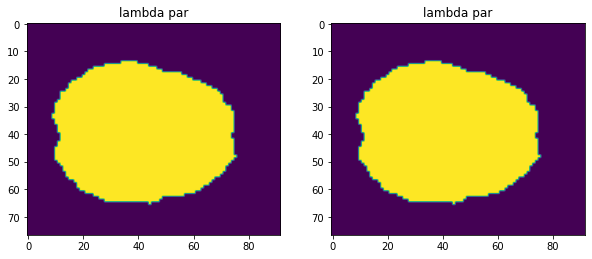

In [17]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1.imshow(l_par[:,:,0])
ax2.imshow(l_par[:,:,1])
ax1.set_title('lambda par')
ax2.set_title('lambda par')

In [18]:
with open('SAS_stick_lambda_par.txt', 'w') as file:
    for line in l_par:
        file.write("%s\n" %line)
        
file.close()